In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setup.
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import os
import json
import collections
import PIL
import wordcloud
import multiprocessing
import seaborn as sns
import bz2
from PIL import Image
from ast import literal_eval
import scipy.stats as stats
import scipy.sparse
from nltk import FreqDist
from matplotlib import colors

# For Word2Vec model training and visualization
from gensim.models import Word2Vec
from gensim.models.word2vec import PathLineSentences
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.decomposition import PCA


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Part 1
## **Data preprocessing**
We selected the data from New York Times as the study corpus because of its great influence all around the world and its multiple well-classified categories. Quotations of New York Times were selected from data spanning the years 2015 to 2020 and preprocessed as follows: 
* We annotated the gender, nationality, occupation, and political party of speakers (as indicated in the dataframe below), and if there were multiple attributions, we utilized the gender and political party of the first speaker for analysis (columns 'first speaker gender' and 'first speaker party').
* We iterated over all of the quotations, tokenized them and added them up.(column "all_words_counts")
* We introduced a list of approximate 100 feminine-masculine word pairings and counted the number and recorded the feminine and masculine words existing in each quotation.(columns "male_word_num","male_words","female_word_num","female_words")
* We introduced another list of 700 words generated by a relative research where volunteers were engaged to evaluate the 700 words (1$<$score$<$7) based on their relation to female or male (For example, if word "woman" is considered more related to female, then the score will be closer to 1, otherwise it will be closer to 7). Then we counted all the words existing in all quotations and computed the sum or mean of the score for analysis.(columns: "politician_word_num", "politician_words", "sum_score")
* Following these data preprocessing steps, the data were stored in csv format for further usage.

In [3]:
# Read the data that we preprocessed previously.
df_2015 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2015_with_people_with_both_words_1.csv')
df_2016 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2016_with_people_with_both_words_1.csv')
df_2017 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2017_with_people_with_both_words_1.csv')
df_2018 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2018_with_people_with_both_words_1.csv')
df_2019 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2019_with_people_with_both_words_1.csv')
df_2020 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2020_with_people_with_both_words_1.csv')
# Data from 2016 serves as an example here.
df_2016.head(3)

,Unnamed: 0,index,Unnamed: 0.1,Unnamed: 0.1.1,index_label,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,category,Gender,Nationality,Occupation,Party,male_word_num,female_word_num,male_words,female_words,year_month,first_speaker_gender,politician_word_num,politician_words,sum_score,all_words_counts,first_speaker_party
0,0,10,10,10,10,2016-06-30-006806,He is hoping that the playwrights and actors h...,Ben Wizner,['Q21498061'],2016-06-30 00:00:00,3,"[['Ben Wizner', '0.8811'], ['None', '0.1063'],...",['http://www.nytimes.com/2016/07/01/theater/ed...,E,uncategorized,[['male']],[['United States of America']],"[['lawyer', 'writer', 'civil rights advocate']]",[['No data']],2,0,"['he', 'actors']",[],2016-06,male,1,['people'],4.185185,29,No data
1,1,11,11,11,11,2016-05-27-031063,He was holding my hands until the end,Sunao Tsuboi,['Q11425715'],2016-05-27 02:29:00,139,"[['Sunao Tsuboi', '0.5736'], ['None', '0.2992'...",['http://www.abqjournal.com/781824/obamas-hug-...,E,politics,[['male']],[['Japan']],[['educator']],[['No data']],1,0,['he'],[],2016-05,male,0,[],0.000000,8,No data
2,2,17,17,17,17,2016-09-07-040636,I just kept pushing her back and tried to make...,Caroline Wozniacki,['Q30767'],2016-09-07 00:00:00,22,"[['Caroline Wozniacki', '0.8121'], ['None', '0...",['http://asia.eurosport.com/tennis/wozniacki-d...,E,sports,[['female']],[['Denmark']],[['tennis player']],[['No data']],0,2,[],"['her', 'her']",2016-09,female,0,[],0.000000,26,No data


## **Useful functions for data visualization**
Here we have several functions for data visualization:
* **func_visualization_0**:
It gives two wordcloud figures showing the most frequently-used feminine words and masculine words.

* **func_visualization_1**: 
It focuses on the analysis on an overall level and includes two lineplots illustrating how the count and ratio of masculine and feminine words change as time change. 

* **func_visualization_2**:
This set of visualization includes two barplots illustrating how feminine words and masculine words are used differently in different categories of the newspaper.

* **func_visualization_3**: 
This visualization facilitates the overview of both the masculine word percentage and all gender-propelled words count in different categories.

* **func_visualization_4**
This visualization includes two pieplots illustrating if people of different genders have a preference for feminine/masculine words.

* **func_visualization_5**
This visualization illustrates the most frequently-used 30 feminine/masculine words by the sum of their counts from 2015 to 2020.

* **func_visualization_6**:
This visualization focuses on the analysis on a party level and has 2 sets of figures.
 * The first set includes all words spoken by Republican and Democratic Party respectively and how many feminine/masculine words detected in Republican quotations and Democratic quotations.
 * The second set reflects the composition of feminine words and masculine words in all words spoken by the Republican and Democratic Party.

* **func_visualization_7**: 
This visualization tries to reflect the gender composition of speakers and how different genders use the two types of words in Republican and Democratic Party. It generates two figures.

* **func_visualization_8**: 
This visualization has two barplots and shows the gender composition of the top 50 speakers with the most sum of spoken words in Republican and Democratic Party. 

* **func_visualization_9**
This visualization has two boxplots showing the score distribution difference on gender and party level. 

More detailed explanation can be found in the following parts.

In [85]:
# Functions for visualization

def sum_words(df):
  """
  Aggregate all the female words and male words used into two lists.
  """
  female_wordlist = []
  male_wordlist = []
  female_df = df[df['female_word_num']!=0].reset_index()
  male_df = df[df['male_word_num']!=0].reset_index()
  for line in range(female_df.shape[0]):
    female_wordlist = female_wordlist + literal_eval(female_df['female_words'][line])
  for line in range(male_df.shape[0]):
    male_wordlist = male_wordlist + literal_eval(male_df['male_words'][line])
  return female_wordlist, male_wordlist

def visualization_0(df):
  """
  Count the times feminine words and masculine words are used.
  Visualize the usage frequency by wordcloud plots.
  """
  female_wordlist, male_wordlist = sum_words(df)
  fdist_female = FreqDist(female_wordlist)
  fdist_male = FreqDist(male_wordlist)
  mask_female = np.array(Image.open('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/female.png'))
  mask_male = np.array(Image.open('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/male.png'))
  wc_female = wordcloud.WordCloud(
        mask = mask_female,
        max_words = 200,
        font_path = '/content/drive/Shareddrives/ADA/Quotes_with_people/caches/CALIBRI.TTF',
        max_font_size = 200,
        background_color = 'white',
        colormap = 'RdYlGn',
        scale = 20)
  
  wc_male = wordcloud.WordCloud(
      mask = mask_male,
      max_words = 200,
      font_path = '/content/drive/Shareddrives/ADA/Quotes_with_people/caches/CALIBRI.TTF',
      max_font_size = 200,
      background_color = 'white',
      scale = 20,
      colormap = 'tab20c')

  fig = plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  wc_female.generate_from_frequencies(fdist_female)
  image_colors = wordcloud.ImageColorGenerator(mask_female)
  plt.imshow(wc_female)
  plt.axis('off')

  plt.subplot(1,2,2)
  wc_male.generate_from_frequencies(fdist_male)
  image_colors = wordcloud.ImageColorGenerator(mask_male)
  plt.imshow(wc_male)
  plt.axis('off')


def visualization_1(dataframe_processed, big_title = None):
  """
  2 lineplots visualize how count and ratio of masculine and feminine words change as time change.
  """
  # Analyze the male/female words as time changes.
  df_male = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('year_month').sum()['male_word_num']
  df_female = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('year_month').sum()['female_word_num']
  df_ratio = df_male/df_female
  fig = plt.figure(figsize=(8,6))

  ## figure 1 How masculine/feminine words counts change?
  plt.subplot(2,1,1)
  plt.xlabel('time')
  plt.ylabel('number of words')
  plt.plot(df_male,label="masculine words",color = '#bacfea')
  plt.plot(df_female,label="feminine words",color = '#f9c1ab')
  y_min, y_max = plt.ylim()
  plt.ylim((y_min, y_max*1.4))
  plt.legend(loc=2)
  plt.xticks(rotation=20)
  plt.title('How does masculine words/feminine words counts change as time goes?',fontsize=11)

  ## figure1-2 How the masculine/feminine words ratio change?
  plt.subplot(2,1,2)
  plt.xlabel('time')
  plt.ylabel('masculine/feminine words')
  plt.xticks(rotation=20)
  plt.plot(df_ratio, color = '#89b4eb')
  plt.title('How about the ratio?',fontsize=11)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def visualization_2(dataframe_processed, big_title=None):
  """
  2 barplots illustrate how feminine and masculine words are used in different categories of the newspaper.
  """
  ## Find out the constitution of masculine and feminine words in different categories.
  df2_1 = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('category').sum()['male_word_num']
  df2_2 = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('category').sum()['female_word_num']
  df2 = pd.concat([df2_1, df2_2],axis=1).fillna(0)

  ## figure 1 Masculine/feminine words counted in different categories.
  plt.figure(figsize=(8,5))
  plt.subplot(1,2,1)
  x_21 = range(df2.shape[0])
  y_21 = [i+0.4 for i in x_21]
  ticks_21 = [i+0.2 for i in x_21]
  label_list = df2.T.columns
  plt.bar(x_21, height = df2['male_word_num'], width=0.4, alpha=0.8, label='masculine words',color='#bacfea')
  plt.bar(y_21, height = df2['female_word_num'], width=0.4, alpha=0.8, label='feminine words',color='#f9c2a9')
  plt.xlabel('category')
  plt.xticks(ticks_21, label_list, rotation=90)
  plt.title('In different categories,\n how are two types of words used?',fontsize=11)
  plt.legend() 

  ## figure 2 In different categories, which type of words is preferred: masculine or feminine?
  plt.subplot(1,2,2)
  bottom_y = df2['male_word_num']/(df2['female_word_num']+df2['male_word_num'])
  plt.ylim((-0.3,1.1))
  plt.bar(x_21,height=bottom_y, width=0.6, alpha=0.8, label='masculine words',color='#bacfea')
  plt.bar(x_21, height=1-bottom_y ,width=0.6, alpha=0.8, bottom=bottom_y, label='feminine words',color='#f9c2a9')
  plt.ylabel('percentage')
  plt.xlabel('category')
  plt.xticks(x_21, label_list, rotation=90)
  plt.legend()
  plt.title('In different categories,\nwhich type of words is preferred?',fontsize=11)
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")
  plt.tight_layout()

def visualization_3(dfs):
  df_percentages = []
  df_sums = []
  for i in range(6):
    df2_1 = dfs[i][dfs[i]['male_word_num']!=0].groupby('category').sum()['male_word_num']
    df2_2 = dfs[i][dfs[i]['female_word_num']!=0].groupby('category').sum()['female_word_num']
    df2 = pd.concat([df2_1, df2_2],axis=1).fillna(0)
    df2['male_word_percentage'] = df2['male_word_num']/(df2['male_word_num']+df2['female_word_num'])
    df2['all_words_detected'] = df2['male_word_num']+df2['female_word_num']
    df_percentages.append(df2['male_word_percentage'])
    df_sums.append(df2['all_words_detected'])
  df3 = pd.concat(df_percentages,axis = 1)
  df4 = pd.concat(df_sums, axis = 1)
  df3.columns = [2015, 2016, 2017, 2018, 2019, 2020]
  df4.columns = [2015, 2016, 2017, 2018, 2019, 2020]
  df3 = df3.T
  df4 = df4.T
  colors = ['#75aaef','#83a8e1','#92a6d2','#a0a4c4','#afa2b5','#bda0a7','#cc9e98','#da9c8a','#e99a7b','#f7986d']
  fig, ax = plt.subplots(2,5,figsize =(10,4),sharey = True, sharex = True)
  for i in range(10):
    sbplt = ax[i%2, i//2]
    sbplt_sub = sbplt.twinx()
    sbplt.plot(df3[df3.columns[i]]*100,'o',color = colors[i])
    sbplt.plot(df3[df3.columns[i]]*100,color = colors[i])
    sbplt.set_title(df3.columns[i])
    sbplt.axhline(y = 50, linestyle= "dashed", color = 'grey',linewidth=2)
    sbplt_sub.bar(df4.index,df4[df4.columns[i]],color = colors[i],alpha = 0.5)
  fig.text(0.5,0,'year')
  fig.text(0,0.25,'masculine words percentage(%)',rotation = 90)
  fig.text(1,0.1,'feminine and masculine words total usage',rotation =270)
  fig.tight_layout()

def visualization_4(dataframe_processed, big_title = None):
  """
  4 pieplots show if people of different genders have a preference for feminine/masculine words.
  """
  ## Who contributes to the use of masculine words and is there any preference?
  df3 = dataframe_processed.groupby('first_speaker_gender').sum()[['male_word_num','female_word_num']].sort_values(by='male_word_num',ascending=False)
  label1 = ['male speakers','female speakers','others']
  label2 = ['masculine','feminine']
  plt.figure(figsize=(8,8))
  plt.subplot(2,2,1)
  plt.pie([df3['male_word_num']['male'],df3['male_word_num']['female'],df3['male_word_num'][2:].sum()],labels= label1,colors=['#bacfea','#fac0ab','#e0e0e0'], wedgeprops={'alpha':0.7}, autopct="%.1f%%")
  plt.title('Who contributes to the use of masculine words?',fontsize=11)
  plt.subplot(2,2,2)
  plt.pie([df3['female_word_num']['male'],df3['female_word_num']['female'],df3['female_word_num'][2:].sum()],labels= label1,colors=['#bacfea','#fac0ab','#e0e0e0'],wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Who contributes to the use of feminine words?',fontsize=11)
  plt.subplot(2,2,3)
  plt.pie([df3['male_word_num']['male'],df3['female_word_num']['male']],labels= label2,colors=['#bacfea','#fac0ab'], wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Males prefer to use:',fontsize=11)
  plt.subplot(2,2,4)
  plt.pie([df3['male_word_num']['female'],df3['female_word_num']['female']],labels= label2, colors=['#bacfea','#fac0ab'],wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Females prefer to use:',fontsize=11)
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")
  plt.tight_layout()

def _barplot(ax1, df):
  """
  1 barplot.
  Compute the most frequently-used feminine words and masculine words.
  Visualize the counts of words by a barplot.
  """
  female_df, male_df = sum_words(df)
  fdist_female = FreqDist(female_df)
  fdist_male = FreqDist(male_df)
  ax1_sub = ax1.twinx()
  ax1.barh(range(30),[-fdist_female.most_common(30)[29-i][1] for i in range(30)],
      tick_label=[fdist_female.most_common(30)[29-i][0] for i in range(30)],color='#fac1a9',)
  ax1_sub.barh(range(30),[fdist_male.most_common(30)[29-i][1] for i in range(30)],
      tick_label=[fdist_male.most_common(30)[29-i][0] for i in range(30)],color='#bacfea')
  ax1.spines['left'].set_visible(False)
  ax1_sub.spines['left'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1_sub.spines['right'].set_visible(False)
  ax1.spines['top'].set_visible(False)
  ax1_sub.spines['top'].set_visible(False)
  plt.xlabel('absolute count')
  plt.tight_layout()


def visualization_5(dfs):
  """
  6 barplots using function _barplot(ax1, df)
  Visualize and compare the data between year 2015 and year 2020.
  """
  fig, (axs) = plt.subplots(1,len(dfs),figsize=(3*len(dfs),6))
  for i in range(len(dfs)):
    _barplot(axs[i], dfs[i])
    plt.title(i+2015)

def visualization_6(df, big_title = None):
  """
  1 barplot visualizes all words spoken by Republican and Democratic Party respectively.
  1 barplot shows how many feminine/masculine words detected in Republican quotations and Democratic quotations.
  2 pieplots reflect the composition of feminine words and masculine words in all words spoken by the Republican and Democratic Party.
  """
  # Select the democratic party and republican party rows.
  df= df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  # How many words do democratic party and republican party say and how is the composition of feminine/masculine words?
  df1 = df.groupby('first_speaker_party').sum()[['male_word_num','female_word_num','politician_word_num','all_words_counts']]
  plt.figure(figsize = (8,7))

  plt.subplot(2,2,1)
  plt.bar(df1.index, df1.all_words_counts,width=0.5,color='#bacfea')
  plt.ylabel('word counts')
  plt.title('all words counts')

  plt.subplot(2,2,2)
  plt.bar(df1.index, df1.male_word_num, width=0.5,color = '#bacfea')
  plt.bar(df1.index, df1.female_word_num, width=0.5,
              bottom=df1.male_word_num,color='#fac1a9')

  for i in range(2):
    plt.text(df1.index[i], (df1.male_word_num[i]+df1.female_word_num[i])+0.05, '%.0f' %(df1.male_word_num[i]+df1.female_word_num[i]), ha='center', va= 'bottom')
    plt.text(df1.index[i], (df1.male_word_num[i])+0.05, '%.0f%%'%(df1.male_word_num[i]/(df1.male_word_num[i]+df1.female_word_num[i])*100) ,ha='center', va= 'bottom')
  plt.ylabel('word counts')
  y_min, y_max = plt.ylim()
  plt.ylim((y_min, y_max*1.3))
  plt.title('masculine/feminine words composition')
  plt.legend(['masculine words','feminine words'], loc=1)

  df1['male_word_ratio'] = df1['male_word_num']/df1['all_words_counts']
  df1['female_word_ratio'] = df1['female_word_num']/df1['all_words_counts']
  plt.subplot(2,2,3)
  labels = ['masculine words','feminine words','other words']
  x_dem = [df1['male_word_ratio']['Democratic Party**'],df1['female_word_ratio']['Democratic Party**']]
  x_dem.append(1-x_dem[1]-x_dem[0])
  plt.pie(x_dem,labels = labels, colors = ['#bacfea','#fac1a9','#e0e0e0'], autopct='%1.1f%%')
  plt.title('\nDemocratic Party')

  plt.subplot(2,2,4)
  x_rep = [df1['male_word_ratio']['Republican Party**'],df1['female_word_ratio']['Republican Party**']]
  x_rep.append(1-x_rep[1]-x_rep[0])
  plt.pie(x_rep,labels = labels, colors = ['#bacfea','#fac1a9','#e0e0e0'], autopct='%1.1f%%')
  plt.title('\nRepublican Party')
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def visualization_7(df,big_title=None):
  """
  1 barplot shows the number of female/male speakers in two Parties.
  1 barplot shows how females/males use the feminine/masculine words in two Parties.
  """
  df= df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  df_2 = df.groupby(['first_speaker_party','first_speaker_gender']).sum()[['male_word_num','female_word_num','all_words_counts']]

  plt.figure(figsize=(8,4))
  # Compute all words spoken by female or male speakers from different Parties.
  plt.subplot(1,2,1)
  male_y = [df_2['all_words_counts']['Democratic Party**']['male'],df_2['all_words_counts']['Republican Party**']['male']]
  female_y = [df_2['all_words_counts']['Democratic Party**']['female'],df_2['all_words_counts']['Republican Party**']['female']]
  labels = ['Democratic Party','Republican Party']
  x = np.arange(len(labels))
  width = 0.4
  plt.bar(x-width/2,male_y,width,label ='male speakers',color ='#bacfea')
  plt.bar(x+width/2, female_y, width,label = 'female speakers', color='#f9c2a9')
  ymin_1, ymax_1 = plt.ylim()
  plt.ylim((ymin_1, ymax_1*1.25))
  ticks = plt.yticks()
  plt.yticks(ticks[0][ticks[0]<=1.1*ymax_1])
  plt.ylabel('number of words')
  plt.legend(loc = 2)
  plt.xticks(x,labels=labels)

  # Compute words composition of female speakers and male speakers in different parties
  plt.subplot(1,2,2)
  male_speak_female_words = [df_2['female_word_num']['Democratic Party**']['male'],df_2['female_word_num']['Republican Party**']['male']]
  male_speak_male_words = [df_2['male_word_num']['Democratic Party**']['male'],df_2['male_word_num']['Republican Party**']['male']]
  female_speak_female_words = [df_2['female_word_num']['Democratic Party**']['female'],df_2['female_word_num']['Republican Party**']['female']]
  female_speak_male_words = [df_2['male_word_num']['Democratic Party**']['female'],df_2['male_word_num']['Republican Party**']['female']]
  labels = ['Democratic Party','Republican Party']
  x = np.arange(len(labels))
  width = 0.4
  plt.bar(x-width/2,male_speak_female_words,width,label ='males speak feminine words',color ='#bacfea')
  plt.bar(x-width/2,male_speak_male_words,width,label ='males speak masculine words',bottom=male_speak_female_words,color ='#89b4eb')
  plt.bar(x+width/2, female_speak_female_words, width,label = 'females speak feminine words', color='#f9c2a9')
  plt.bar(x+width/2, female_speak_male_words, width,label = 'females speak masculine words',bottom=female_speak_female_words, color='#fa9b73')
  for i in range(2):
    plt.text(x[i]-width/2, male_speak_female_words[i]+0.05, '%.0f%%'%(male_speak_female_words[i]/(male_speak_female_words[i]+male_speak_male_words[i])*100), ha='center', va= 'bottom')
    plt.text(x[i]+width/2, female_speak_female_words[i]+0.05, '%.0f%%'%(female_speak_female_words[i]/(female_speak_female_words[i]+female_speak_male_words[i])*100), ha='center', va= 'bottom')
    plt.text(x[i]-width/2, male_speak_female_words[i]+male_speak_male_words[i]+0.05, '%.0f'%(male_speak_female_words[i]+male_speak_male_words[i]),ha='center', va= 'bottom')
    plt.text(x[i]+width/2, female_speak_female_words[i]+female_speak_male_words[i]+0.05, '%.0f'%(female_speak_female_words[i]+female_speak_male_words[i]),ha='center', va= 'bottom')
  
  ymin_2, ymax_2 = plt.ylim()
  plt.ylim((ymin_2, ymax_2*1.5))
  ticks = plt.yticks()
  plt.yticks(ticks[0][ticks[0]<=1.1*ymax_2])
  plt.xticks(x,labels=labels)
  plt.ylabel('number of words')
  plt.legend(loc=2)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def count_speaker_gender(df):
  """
  Count the number of female/male speakers in every 5 speakers among the top 50 speakers.
  For example, among the first 1-5 speakers: there are 4 males and 1 female.
  """
  female_speaker_counts = []
  male_speaker_counts = []
  df_to_sort = df.groupby(['speaker','first_speaker_gender','first_speaker_party']).sum().sort_values(by='all_words_counts',ascending = False)
  for i in range(10):
    if len(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count().index)==2:
      female_speaker_counts.append(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count()['index']['female'])
      male_speaker_counts.append(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count()['index']['male'])
    elif df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count().index[0] == 'female':
      female_speaker_counts.append(5)
      male_speaker_counts.append(0)
    else:
      female_speaker_counts.append(0)
      male_speaker_counts.append(5)
  ratios = []
  for i in range(len(female_speaker_counts)):
    ratios.append(male_speaker_counts[i]/(male_speaker_counts[i]+female_speaker_counts[i]))
  return female_speaker_counts, male_speaker_counts, ratios

def visualization_8(df, big_title = None):
  """
  Visualize the different gender composition in every 5 speakers among the top 50 speakers in two Parties.
  """
  df1 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  df2 = df.query("first_speaker_party == 'Democratic Party**'")
  df3 = df.query("first_speaker_party == 'Republican Party**'")
  # Plot the female_speaker/male_speaker number in the 50th most "influential" speakers (5 as an interval)
  fe_num, ma_num, _ = count_speaker_gender(df1)
  fe_num_d, ma_num_d, _ = count_speaker_gender(df2)
  fe_num_r, ma_num_r, _ = count_speaker_gender(df3)
  plt.figure(figsize = (7,5))
  plt.subplot(2,1,1)
  x = ['1-5','6-10','11-15','16-20','21-25','26-30','31-35','35-40','41-45','46-50']
  plt.bar(x, fe_num_d, label = 'female speaker',color = '#fac1a9')
  plt.bar(x, ma_num_d, bottom = fe_num_d, label = 'male speaker',color = '#bacfea')
  plt.ylim((-0.5,5.5))
  plt.xlim((-1,13.5))
  plt.title('gender composition in Democratic Party')
  plt.legend(loc = 7)
  plt.subplot(2,1,2)
  plt.bar(x, fe_num_r, label = 'female speaker',color = '#fac1a9')
  plt.bar(x, ma_num_r, bottom = fe_num_r, label = 'male speaker',color = '#bacfea')
  plt.ylim((-0.5,5.5))
  plt.xlim((-1,13.5))
  plt.title('gender composition in Republican Party')
  plt.legend(loc = 7)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def visualization_9(df, big_title):
  """
  2 boxplots visualize the distribution of scores achieved by speakers of two Parties.
  """
  df = df[df['politician_word_num']!=0].copy()
  df['average_score'] = df['sum_score']/df['politician_word_num']
  df1 = df.query('first_speaker_gender =="female" or first_speaker_gender =="male"')
  plt.figure(figsize = (8,4))
  plt.subplot(1,2,1)
  # plot the distribution of scores of different genders
  sns.boxplot(x='first_speaker_gender', y='average_score', data = df1, palette = ['#fac1a9','#bacfea'], width=0.3)
  plt.xlabel('gender of speaker')
  plt.ylabel('average score (1-7)')
  plt.title('score distribution on different gender')
  # plot the distribution of scores of different parties
  df2 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  plt.subplot(1,2,2)
  sns.boxplot(x='first_speaker_party', y='average_score',data =df2,palette = ['#89b4eb','#fa9b73'],width=0.3)
  plt.xlabel('party of speaker')
  plt.ylabel('average score (1-7)')
  plt.title('score distribution on different parties')
  plt.tight_layout()
  plt.subplots_adjust(top=0.87)
  plt.suptitle(big_title,fontweight ="bold")

## **1. Introduction**
With the development of the whole society, the public is becoming more aware of gender inequality. Despite the fact that several proposals have been made to address gender imbalance, it is still unclear if the situation has improved.

The quote database provided us with an excellent corpus to examine the subject. The New York Times was chosen as the research corpus for this section owing to its widespread effect and a variety of other factors. We first chose about 100 pairs of feminine and masculine phrases (for example, actress - actor, she - he) and counted how many times these feminine/masculine words appeared in quotations from the New York Times from 2015 to 2020. Then we looked at the gender of the speakers to see if gender had an impact on whether speakers chose feminine or masculine terms. We also compared the frequency of masculine/feminine words usage in different fields and different political parties and achieved quite interesting results.

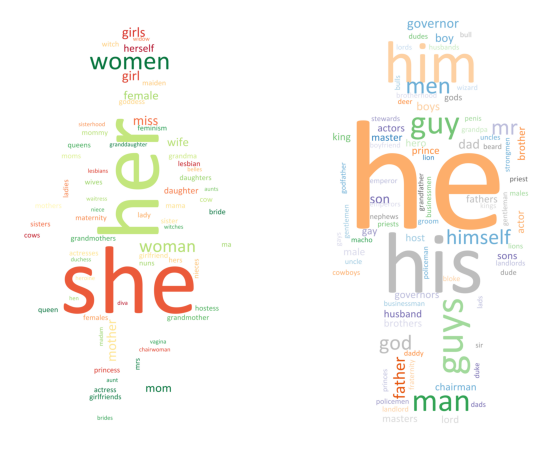

In [ ]:
# Introduction: the most frequently-used feminine/masculine words
visualization_0(df_2016)

## **2. Statistics**
**Note**: Our analysis is based on data from 2015 to 2020.

### **2.1. Language**
#### **How masculine/feminine words counts and ratio change as time goes?**
In the first two line plots, we visualized the change of counts and ratio of masculine/feminine words throughout a year (2015-2020). From these line plots, on one hand, we can observe an almost random change in the counts of masculine and feminine words and masculine/feminine ratio, and on the other hand, most of the masculine/feminine ratios are over 1, which indicates a higher usage of masculine words than feminine words.
Next, we examined the masculine/feminine words usage in different categories, as well as the gender of speakers to find out possible explanations of this intriguing phenomenon.

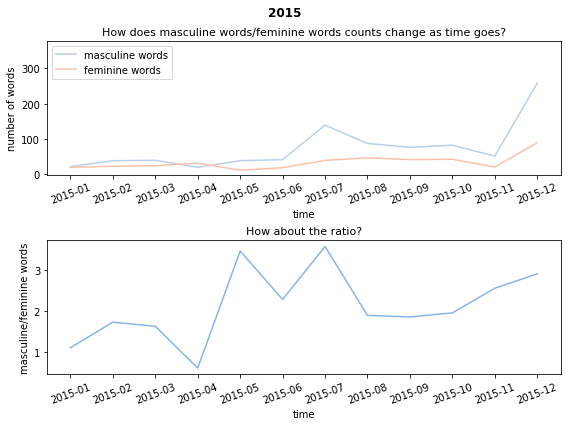

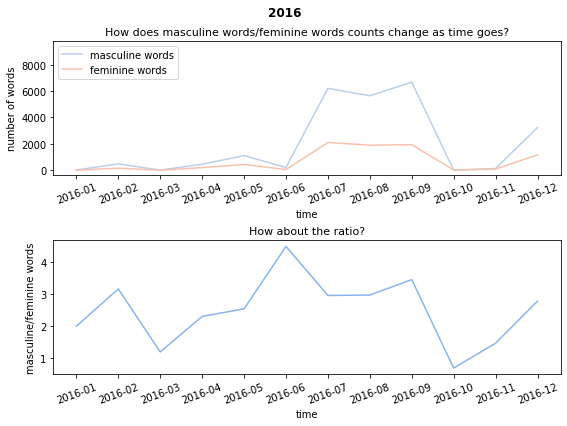

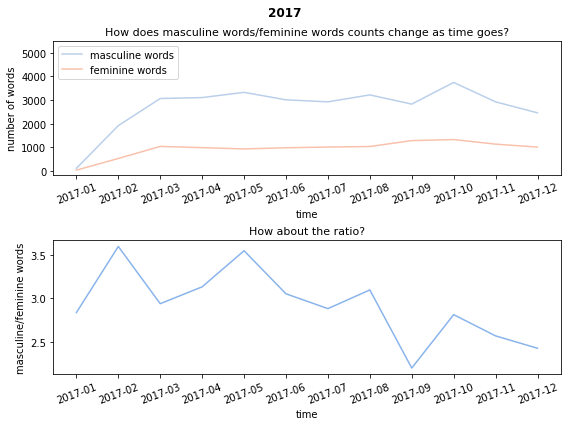

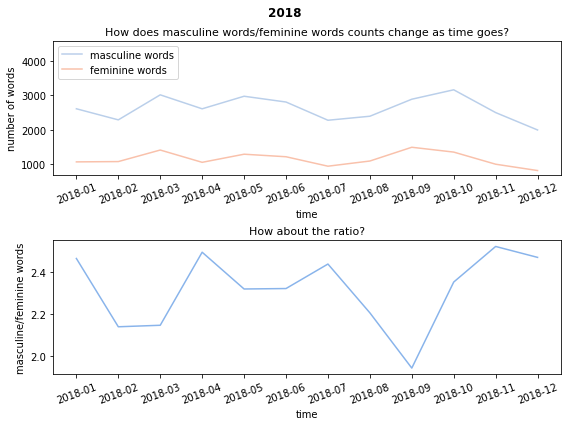

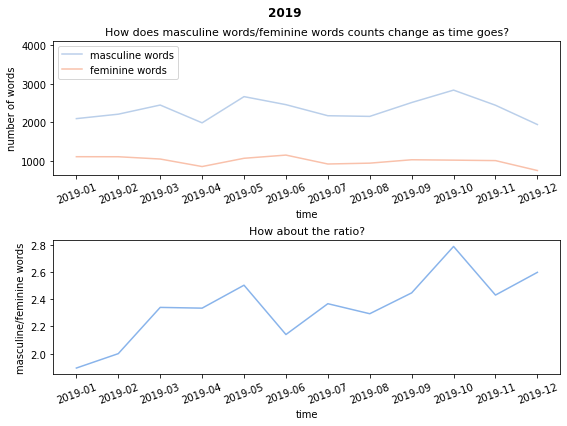

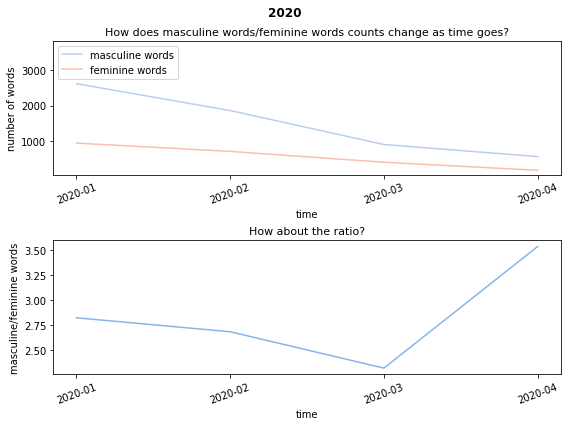

In [82]:
dfs = [df_2015, df_2016, df_2017, df_2018, df_2019, df_2020]
titles = [2015, 2016, 2017, 2018, 2019, 2020]
for i in range(len(dfs)):
  visualization_1(dfs[i], titles[i])

#### **How masculine/feminine words are used in different categories?**
Quotations were first categorized into different fields and the masculine/feminine words ratio was computed in every field. For most fields, the masculine words percentage is higher than 50% and the phenomenon is commonly observed in dataset from 2015 to 2020.

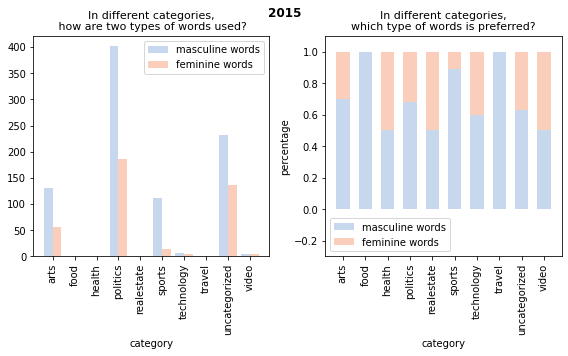

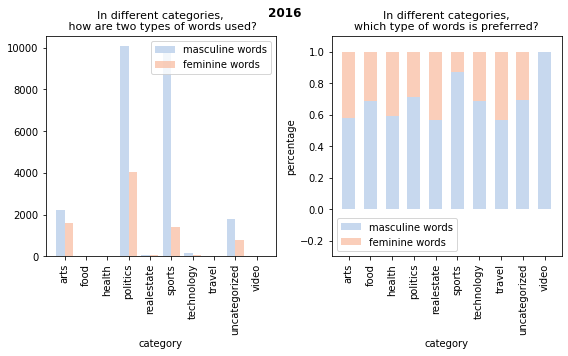

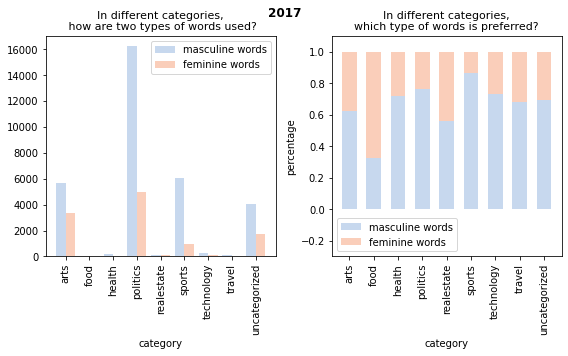

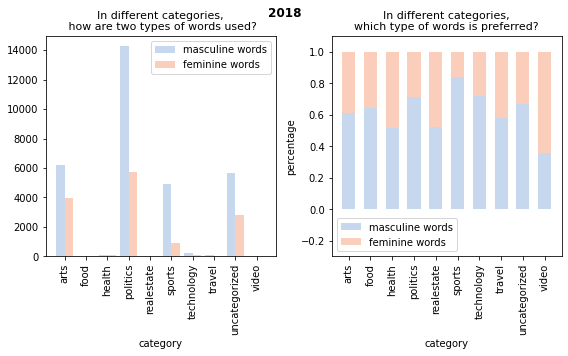

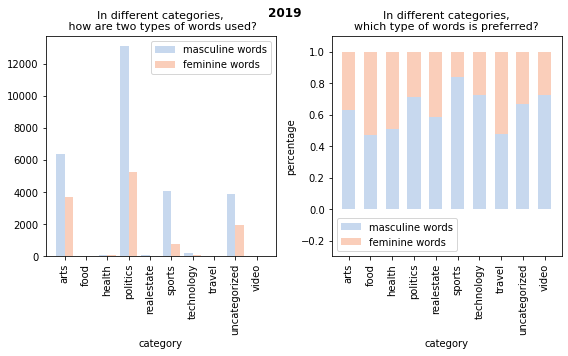

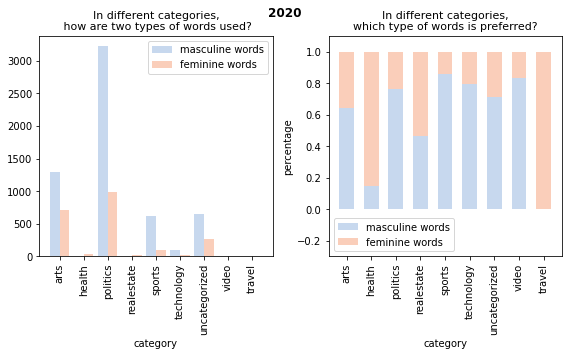

In [8]:
for i in range(len(dfs)):
  visualization_2(dfs[i], titles[i])

We also note that for some hit topics (with higher total word usage) such as politics, sports, and arts, the masculine words percentage is always higher than 0.5 while for topics like real-estate, masculine/feminine words ratio is always not that high (0.5~0.6). For topics like health, food, travel, and video, the masculine words percentage fluctuates sharply around 50% which may be resulted from a small volume of samples. 

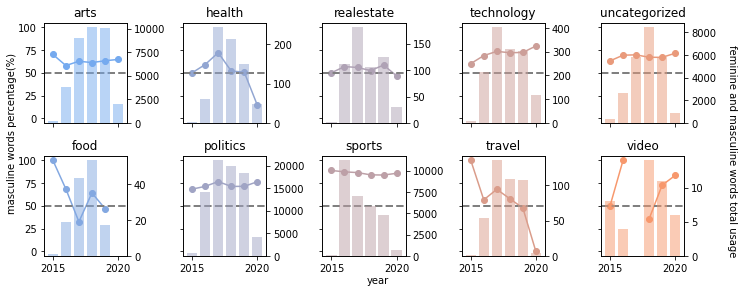

In [9]:
visualization_3(dfs)

### **2.2. Language And Gender**
#### **Who contributes to the use of masculine/feminine words?**
The information of the speakers was then incorporated for comparison, and speakers of masculine and feminine terms were classified by gender, with the findings shown in the four pie charts. From the first 2 pie plots, we can see that for the usage of both masculine and feminine words, male speakers have more contribution than female speakers. By comparing the composition of words used by males and females, we found that males prefer to use masculine words while females use almost equally masculine words and feminine words. So far, we seem to be able to partly explain why masculine words are used more than feminine words: males speak “more”, or in other words, males have more opportunity to speak than females, and meanwhile, males tend to speak much more masculine words than feminine words.

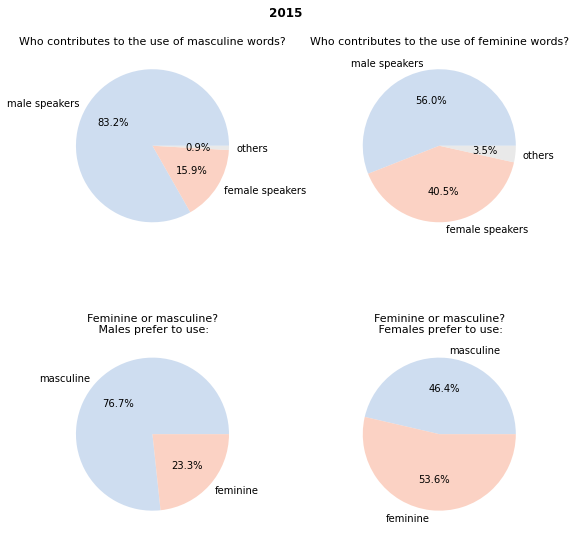

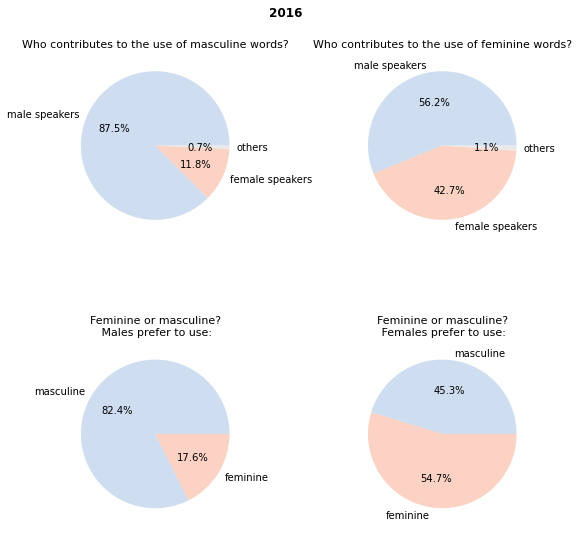

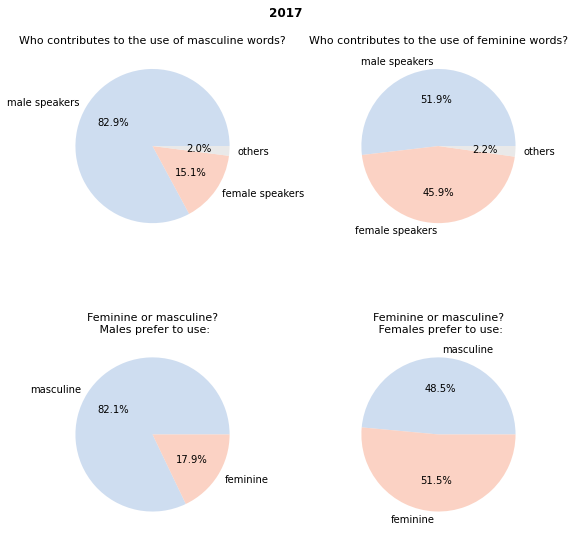

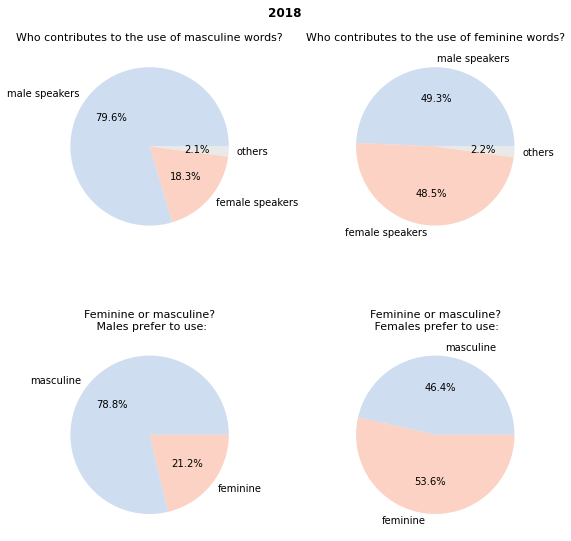

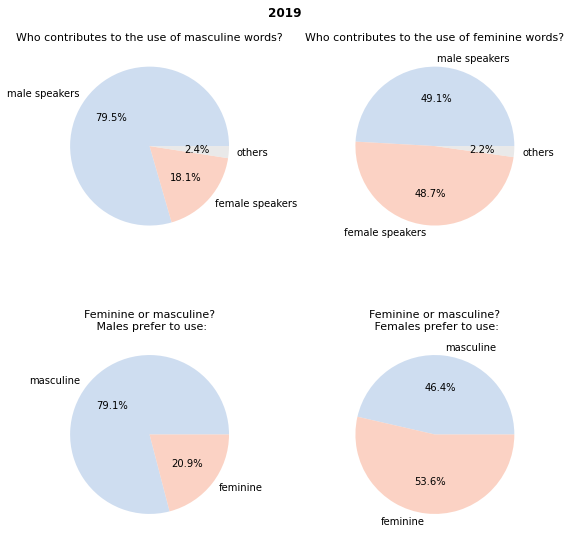

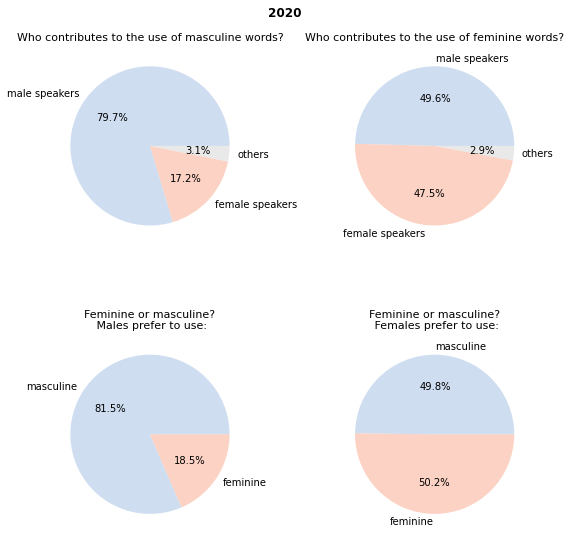

In [10]:
for i in range(len(dfs)):
  visualization_4(dfs[i], titles[i])

#### **What are the most frequently-used feminine/masculine words?**
Between 2015 and 2020, in the 30 most frequently-used feminine words "witch" ("wizard"), "vagina" ("penis"), "girlfriend" ("boyfriend"), "maiden" ("bachelor"), "spinster" ("bachelor"), "feminism" ("masculism") can't find their masculine-pairs in the corresponding 30 most frequently-used masculine words, whereas "god" ("goddess"), "governor" ("governess"), "chairman" ("chairwoman"), "master" ("mistress") can't find their feminine-pairs in the corresponding 30 most frequently-used masculine words.

From this word list, we can also discover something interesting if we believe that more frequently-used words are better representative of the image of a gender in the social media. The most frequently used feminine words including "woman", "girl", "wife", "daughter", "sister", "lady", "queen", "girlfriend", "witch", "princess" are considered to be the major characters of a female in a society, whereas "man", "guy", "god", "father", "governor", "actors", "husband", "brother", "king", "hero", "chairman" are the main characteristics of a male in a culture.

From these results, we can notice that males are more related to leadership than females in the society because we didn't find "chairwoman", "governess" or "mistress" in the most frequently-used feminine lists. Meanwhile, females may be potentially considered as the accessories of males as "boyfriend", the pair word for "girlfriend", never appears on the most popular masculine list. Comparing the popular titles for males (Mr.) and females (Mrs. and Miss), females still seem to be categorized into married and not married. However, there is less discussion on whether a male is married or not since "spinster" (describing a woman who spins wool for fabric, having long been associated with unattractive old maids), "maiden" (unmarried woman, sometimes refering to an older unmarried woman) are on the most popular feminine wordlist when their masculine word pair "bachelor" is not on the most popular masculine wordlist despite the fact that almost 2 million people are achieving their "bachelor" degrees every year. 

However, there're still encouraging discoveries. Word "feminism" being among the most popular feminine wordlist from 2017 to 2019 indicates the gender inequality is more and more concerned in the recent years. Meanwhile, the elimination of negative feminine words "spinster" and "maiden" from the most popular feminine wordlist is a good sign for the development of social improvement. 

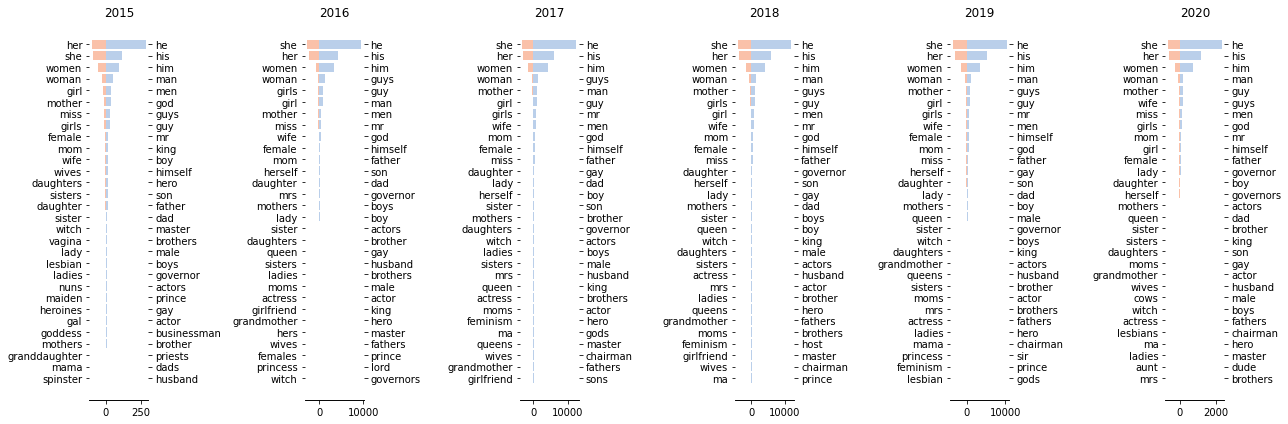

In [11]:
visualization_5(dfs)

### **2.3. Language, Gender, and Partisanship**
The following discovery was enlightened by a relative [research](https://journals.sagepub.com/doi/full/10.1177/1065912919874883) where researches found the Republican Party uses more masculine language than the Democratic Party in their official party platform. The Quotebank dataset provided us an opportunity to verify this statement -**if there really exists a difference between languages used by Republican Party and Democratic Party?**

First, we can take a look at the gender composition on an overall level, we can notice that despite the difference in the sum of word tokens from Democratic Party and Republican Party, the Republican always use masculine words at a higher rate than the Democratic.

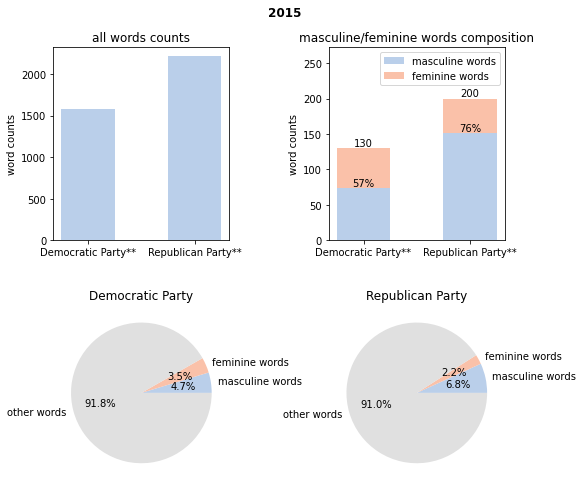

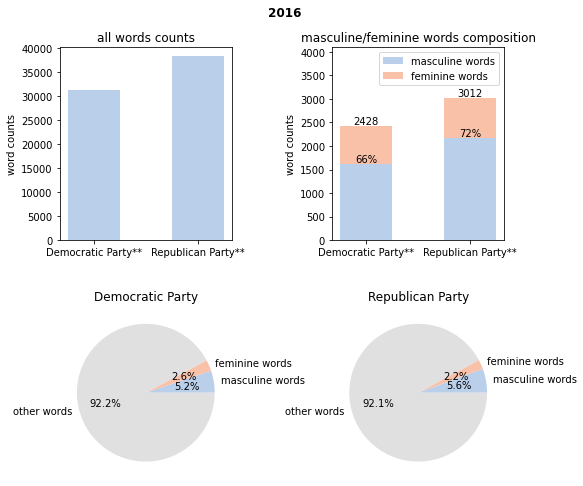

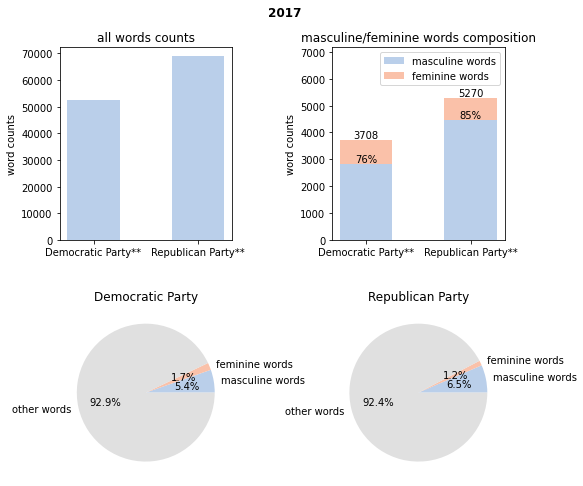

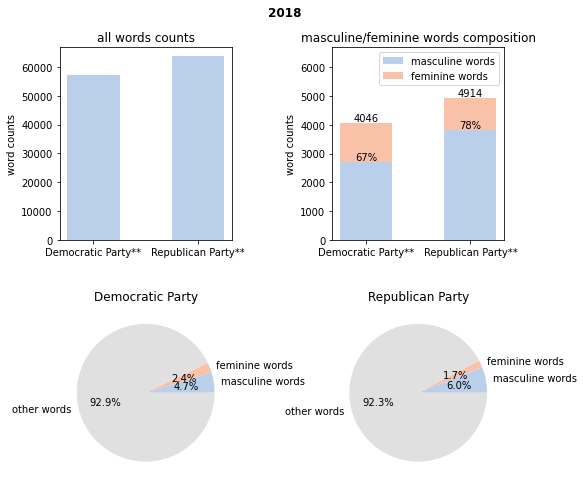

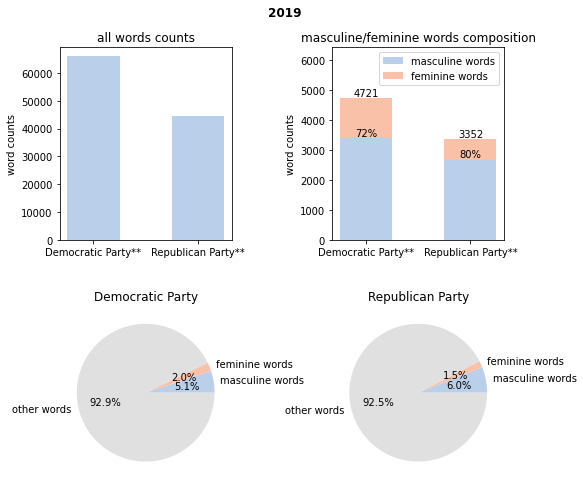

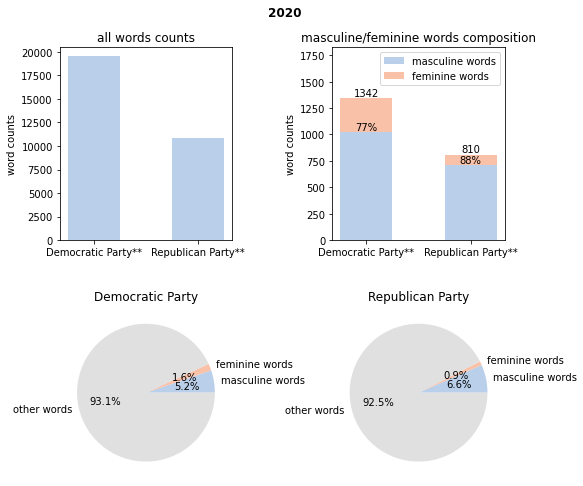

In [86]:
for i in range(len(dfs)):
  visualization_6(dfs[i],titles[i])

#### **How is the speaker composition in two Parties?**
Then, we inspected on how much female speakers and male speakers contribute to feminine words and masculine words usage in two Parties respectively and found out that in Democratic Party, the ratio of female speakers to male speakers is always more balanced than in Republican Party, indicating women have more chance to voice in Democratic Party. Another auxiliary evidence is that Hillary Clinton, the first woman to win a presidential nomination by a major U.S. political party, comes from Democratic Party. 

We also found similar phenomenon that male speakers tend to speak more masculine words than females in both Parties. In five of six years concerned, both females and males in Democratic Party tend to speak more feminine words than females and males in Republican Party. Recapping previous discovery that in topic like politics, the masculine words percentage is always far higher than 50%, we noticed from year 2016 to 2020, female and male speakers from both Parties tend to speak more masculine words than feminine words, and the percentage of masculine words these politicians use is higher than the average of the whole dataset of each year.

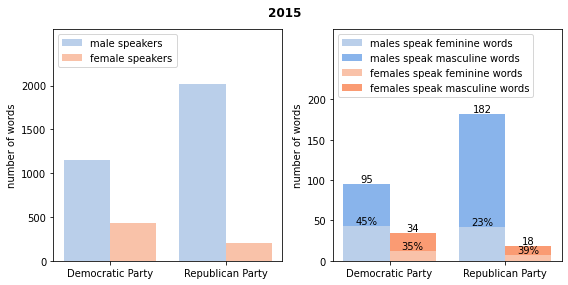

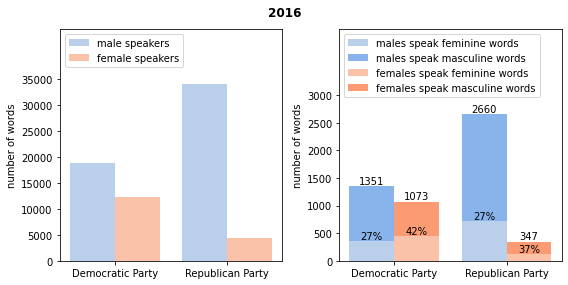

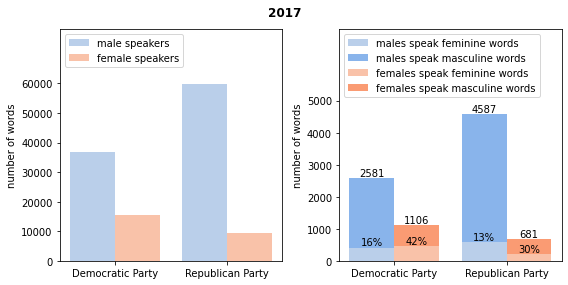

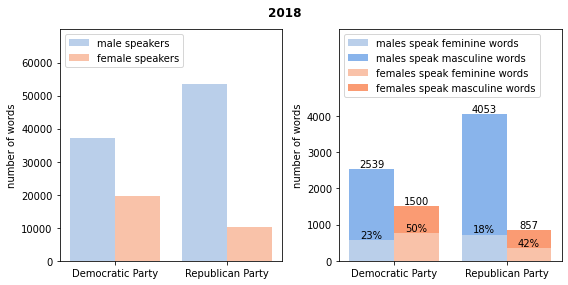

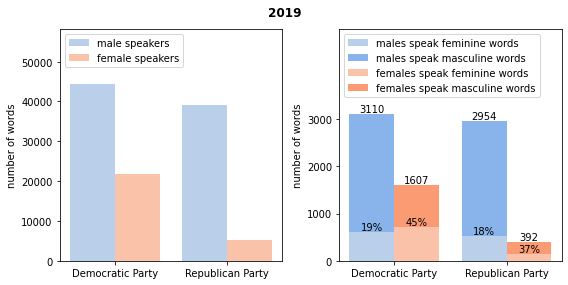

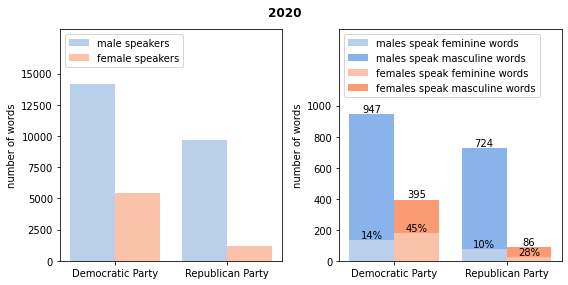

In [78]:
for i in range(len(dfs)):
  visualization_7(dfs[i],titles[i])

#### **How is the gender composition in "the most influential speakers"?**
If we assume that speakers with more spoken words detected are more “influential”, we can then display the gender composition in the 50 "most influential" speakers in Democratic Party and Republican Party. First we noticed that the majority of "most influential speakers" is male. However, if we try to compare between two Parties, Democratic Party consistently has more female speakers among the top 50 “most influential” speakers.

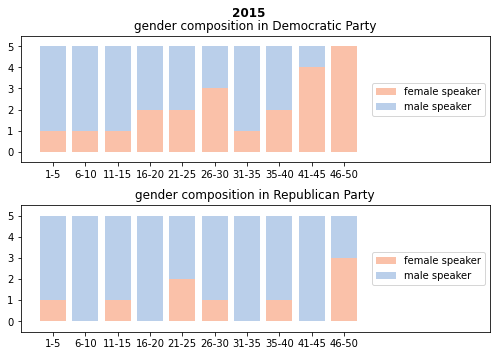

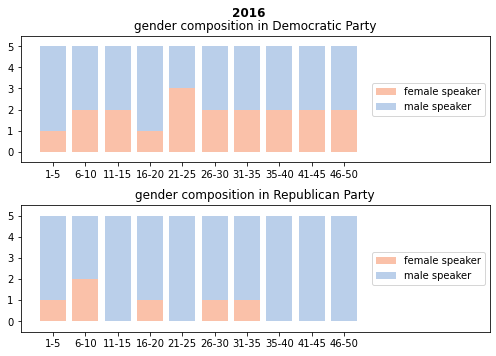

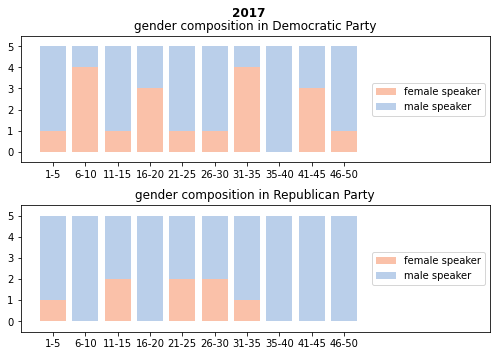

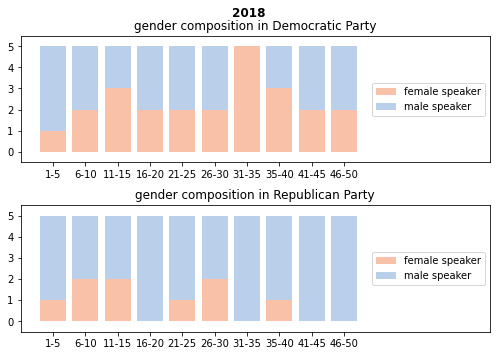

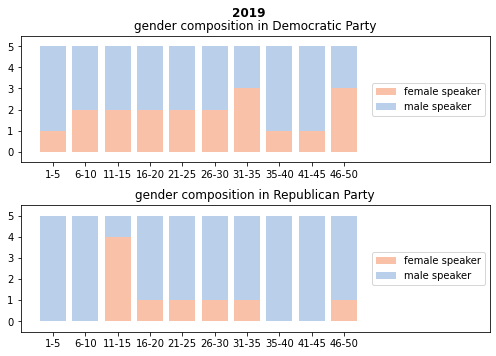

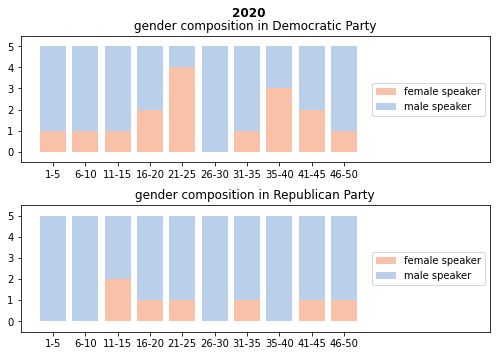

In [14]:
for i in range(len(dfs)):
  visualization_8(dfs[i],titles[i])

##### **Statistical analysis 1:** Compare the gender composition (gender ratio) in the top 50 speakers with most spoken words.

In order to confirm our preliminary observation, we examined if the ratio of male speakers to female speakers is statistically different between Democratic Party and Republican Party by t-test. Except for year 2017 (p-value = 0.058), t-test for the other 5 years shows that a statistically difference exists between the male to female ratio between two Parties. 

In [ ]:
def statistical_analysis_1(df):
  """
  Compute the p-value on the two distribution.
  """
  df1 = df.query("first_speaker_party == 'Democratic Party**'")
  df2 = df.query("first_speaker_party == 'Republican Party**'")
  _,_, ratio_d = count_speaker_gender(df1)
  _,_, ratio_r = count_speaker_gender(df2)
  _,p_levene = stats.levene(ratio_d,ratio_r)
  if p_levene >0.05:
    print('p-value({}) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances'.format(p_levene))
  else:
    print('p-value({}) of levene test is <0.05, indicating statistically significant evidence shows two distributions have different variances'.format(p_levene))
  # According to the levene result, no statistically significant evidence shows two distributions have different variances.
  _,p_ttest = stats.ttest_ind(ratio_d,ratio_r)
  if p_ttest <0.05:
    print('p-value({}) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.'.format(p_ttest))
  else:
    print('p-value({}) of t-test is > 0.05, indicating no evidence shows the mean value of two distributions are statistically different.'.format(p_ttest))

  # p<0.05 indicates two samples are statistically different at 95% confidence level.

for i in range(len(dfs)):
  print(titles[i])
  statistical_analysis_1(dfs[i])

2015
p-value(0.42395277691927025) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.02766703937466151) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.
2016
p-value(0.11770150905630472) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.00024024631448353167) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.
2017
p-value(0.4988298659457183) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.05771722672432426) of t-test is > 0.05, indicating no evidence shows the mean value of two distributions are statistically different.
2018
p-value(0.7730461433085736) of levene test is >0.05, indicating no statistically significant evidence shows two distributions 

#### **If the results achieved by the paper is also valid in our dataset?**
We introduced the word list generated by the research with scores on 700 selected words (ranging from 1-7, most feminine - most masculine), extracted speakers who have used words from this wordlist and computed an average score for each speakers. We initialized a simple and naive comparison by first ignoring the influence from different Parties and just dividing our samples into female/male pair groups and visualized the score distribution in female/male groups. We found except year 2015, males always have a higher mean score than females. The result is consistent to what we discovered previously that males prefer to use more masculine words (with scores more positive to 7) than females and thus the average score will be higher (more masculine). Then we divided the whole dataset into Republican Party and Democratic Party groups and also visualized the distribution of scores. Interestingly, compared to Democratic Party, Republican Party always has a higher average score, suggesting that Republican Party uses more masculine words than Democratic Party. In other words, the way Republican speakers use feminine/masculine words is more like females while Democratic speakers behave more like males. One naive and plausible explanation is that the different gender composition results in the difference between languages used by two Parties but solid statistical analyses are still necessary.

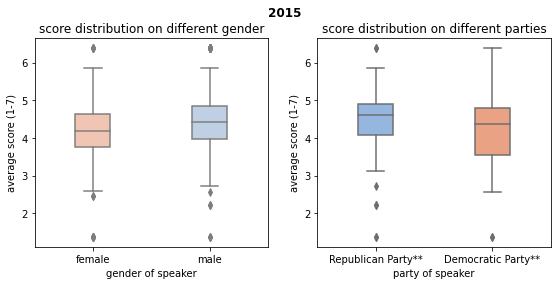

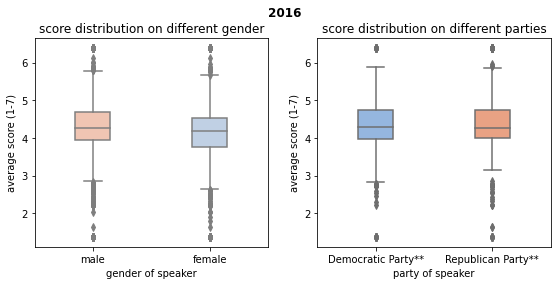

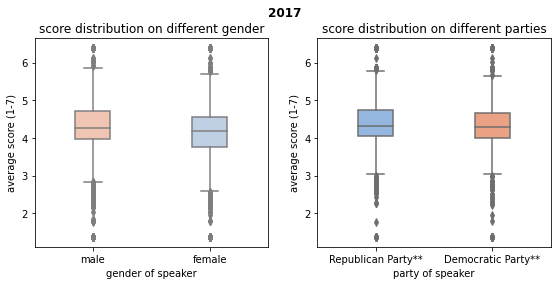

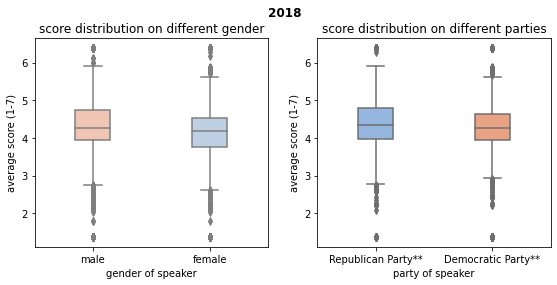

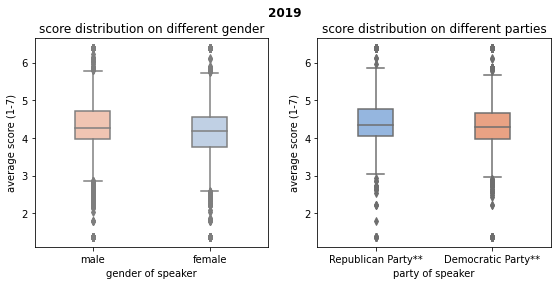

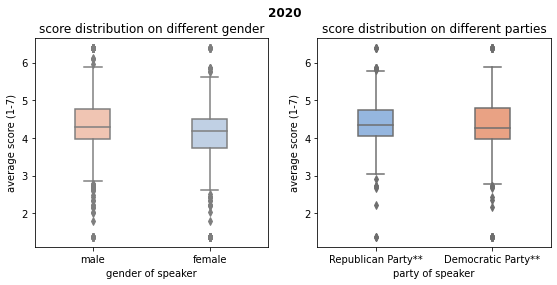

In [ ]:
for i in range(len(dfs)):
  visualization_9(dfs[i],titles[i])

##### **Statistical analysis 2:** Compare the mean of scores achieved by Democratic Party and Republican Party.

In [ ]:
def statistical_analysis_2(df):
  df = df[df['politician_word_num']!=0].copy()
  df['average_score'] = df['sum_score']/df['politician_word_num']
  df2 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  # perform t-test on different groups
  _, p_levene = stats.levene(df2[df2['first_speaker_party']=='Democratic Party**']['average_score'],df2[df2['first_speaker_party']=='Republican Party**']['average_score'])
  if p_levene > 0.05:
    print('p-value({}) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances'.format(p_levene))
  else:
    print('p-value({}) of levene test is <0.05, indicating statistically significant evidence shows two distributions have different variances'.format(p_levene))
  # According to the levene result, no statistically significant evidence shows two distributions have different variances.
  _, p_ttest = stats.ttest_ind(df2[df2['first_speaker_party']=='Democratic Party**']['average_score'],df2[df2['first_speaker_party']=='Republican Party**']['average_score'])
  if p_ttest < 0.05:
    print('p-value({}) of t-test is < 0.05, indicating the mean values of two distributions are statistically different.'.format(p_ttest))
  else:
    print('p-value({}) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.'.format(p_ttest))

for i in range(len(dfs)):
  print(titles[i])
  statistical_analysis_2(dfs[i])

2015
p-value(0.17559740365803492) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.4744630733690447) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.
2016
p-value(0.26677313171295186) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.34884183129659396) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.
2017
p-value(0.7377950078790122) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.0011800111135578538) of t-test is < 0.05, indicating the mean values of two distributions are statistically different.
2018
p-value(0.6385520579299859) of levene test is >0.05, indicating no statistically significant evidence shows

In order to statistically prove that there exists a difference between languages used by Republican Party and Democratic Party, we also implemented t-test here. However, the preliminary assumption doesn't hold for all years. After conducting a t-test to compare the scores obtained by speakers from the Republican and Democratic parties, the p-values are smaller than 0.05 in 2017, 2018, 2019, indicating a statistical difference in the use of language between the Democratic and Republican parties in these years at 95% confidence level. However, no evidence shows difference exists in 2015, 2016, 2020. The interesting thing is that the turning point coincides with the presidential change (2017: Barack Obama to Donald Trump) and it’s also pointed out in the research that Donald Trump is regarded as a hyper-masculine politician by some but we still need more data to dig into this hypothesis. 

# Part 2 Gender bias indeed exists: from the view of word embeddings
Gender bias has been shown to be captured by a direction in the word embedding [1]. In this section, we further explore the female/male gender bias in the Quotebank [2] dataset by using word2vec algorithm [3] to learn word associations from the large corpus of Quotebank’s quotations.
## Embedding Training
We obtained a word2vec model with 49996-word embeddings of dimension 100 after 10 epoch’s training on Quotebank’s quotations from 2015 to 2020 (we made the words lower-case and digits, punctuation and words with lower frequencies than certain threshold were discarded). 

In [ ]:
# Callback class for model training
class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self, year):
        self.epoch = 1
        self.losses = []
        self.year = year

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        
        if self.epoch % 5 == 0:
          model.save("models_tmp_100d/" + self.year + "_word2vec_epoch_" + str(self.epoch) + ".model")
        self.epoch += 1
        print(self.year)
        print(self.losses)

In [ ]:
# Train the Word2Vec model
model = Word2Vec(PathLineSentences('all_text'),
        size=100, window=5, max_final_vocab=50000, compute_loss=True,
        workers=multiprocessing.cpu_count()*2, iter=10, sg=1)
model.save( "./models/all_word2vec.model")

In [ ]:
# Read names to filter them out in the model
with open('./wordlists/female_names.txt', 'r') as fin:
    female_names = fin.readlines()
    female_names = [w.strip().lower() for w in female_names]

with open('./wordlists/male_names.txt', 'r') as fin:
    male_names = fin.readlines()
    male_names = [w.strip().lower() for w in male_names]
    
names = female_names + male_names
names_pl = [w + 's' for w in names]
names = names + names_pl

In [ ]:
# Load model
model = Word2Vec.load('./models/all_word2vec.model').wv

words = sorted([w for w in model.vocab if w not in names],
               key=lambda w: model.vocab[w].index)
vecs = [model[w] for w in words]

## Useful functions for data analysis and visualization
Here we have several functions for data analysis and visualization:
* **WordEmbedding**:
It post-process the word embeddings obtained and do analysis on them. Functions include:
    - **best_analogies_dist_thresh**: It finds the best analogies matching given analogy (like 'he'-'she'). Metric is $cos(a-c, b-d)$ if $|b-d|^2 < thresh$, otherwise $0$.
    - **find_extreme_words**: It finds the extremest words in the given word set to the given axes (like 'he' axis and 'she' axis). Metric is $cos(a, x) - cos(a, y)$.

* **display_bar_plot**: 
It visualizes the components on the given axes of word embeddings.

* **display_pca_scatterplot**: 
It does PCA to reduce the dimension of embeddings to 2 and visualize them with a scatter plot.


In [ ]:
# WordEmbedding class for embedding analysis
class WordEmbedding:
    """ Adpated from https://github.com/tolga-b/debiaswe/blob/master/debiaswe/we.py
    """
    def __init__(self, words, vecs):
        self.thresh = None
        self.max_words = None
        self.vecs = np.array(vecs, dtype='float32')
        self.words = words
        self.reindex()
        norms = np.linalg.norm(self.vecs, axis=1)
        if max(norms) - min(norms) > 0.0001:
            self.normalize()

    def reindex(self):
        self.index = {w: i for i, w in enumerate(self.words)}
        self.n, self.d = self.vecs.shape
        assert self.n == len(self.words) == len(self.index)
        self._neighbors = None

    def v(self, word):
        return self.vecs[self.index[word]]

    def diff(self, word1, word2):
        v = self.vecs[self.index[word1]] - self.vecs[self.index[word2]]
        return v/np.linalg.norm(v)

    def normalize(self):
        self.vecs /= np.linalg.norm(self.vecs, axis=1)[:, np.newaxis]
        self.reindex()

    def compute_neighbors_if_necessary(self, thresh, max_words):
        thresh = float(thresh)
        if self._neighbors is not None and self.thresh == thresh and self.max_words == max_words:
            return
        print("Computing neighbors")
        self.thresh = thresh
        self.max_words = max_words
        vecs = self.vecs[:max_words]
        dots = vecs.dot(vecs.T)
        dots = scipy.sparse.csr_matrix(dots * (dots >= 1-thresh/2))
        from collections import Counter
        rows, cols = dots.nonzero()
        nums = list(Counter(rows).values())
        print("Mean:", np.mean(nums)-1)
        print("Median:", np.median(nums)-1)
        rows, cols, vecs = zip(*[(i, j, vecs[i]-vecs[j]) for i, j, x in zip(rows, cols, dots.data) if i<j])
        self._neighbors = rows, cols, np.array([v/np.linalg.norm(v) for v in vecs])


    def best_analogies_dist_thresh(self, v, thresh=1, topn=500, max_words=50000):
        """Metric is cos(a-c, b-d) if |b-d|^2 < thresh, otherwise 0
        """
        vecs, vocab = self.vecs[:max_words], self.words[:max_words]
        self.compute_neighbors_if_necessary(thresh, max_words)
        rows, cols, vecs = self._neighbors
        scores = vecs.dot(v/np.linalg.norm(v))
        pi = np.argsort(-abs(scores))

        ans = []
        usedL = set()
        usedR = set()
        for i in pi:
            if abs(scores[i])<0.001:
                break
            row = rows[i] if scores[i] > 0 else cols[i]
            col = cols[i] if scores[i] > 0 else rows[i]
            if row in usedL or col in usedR:
                continue
            usedL.add(row)
            usedR.add(col)
            ans.append((vocab[row], vocab[col], abs(scores[i])))
            if len(ans)==topn:
                break

        return ans
    
    def find_extreme_words(self, anchor_words, candidates, num):
        sp = sorted([(self.v(w).dot(self.v(anchor_words[1])) - self.v(w).dot(self.v(anchor_words[0])), w) for w in candidates if w in words])
        return sp[: select_words_num], sp[-select_words_num: ]

In [ ]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#82111f'
color_blue = '#144a74'
color_black = '#692a1b'

# Draw bar plot
def display_bar_plot(words, he, she, type_of_words):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.grid(False)
    ax.set_facecolor(facecolor)
    ax.barh(words, he, align='center', color=color_red, zorder=10, alpha=0.8)
    ax.barh(words, she, align='center', color=color_blue, zorder=10, alpha=0.8)
    ax.set_title("Components of extreme %s words in the 'he'-axis and 'she'-axis directions" % type_of_words, fontsize=14, pad=15, color=font_color, **hfont)
    plt.legend(labels=["'he'-axis component","'she'-axis component"], bbox_to_anchor=(1,0), loc="lower right", fontsize=6)
    ax.set(yticks=words, yticklabels=words)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set(fontsize=10, color=font_color, **hfont)
    plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
    fig.tight_layout()
    filename = type_of_words
    plt.savefig(filename+'.png')
    
# Draw scatter plot
def display_pca_scatterplot(model, words_anchor, words_he, words_she, type_of_word):
    words = words_anchor + words_he + words_she
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:, :2]
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_facecolor(facecolor)
    st = 0
    end = len(words_anchor)
    plt.scatter(twodim[: 1][:,0], twodim[: 1][:,1], s=200, edgecolors='face', c=color_red)
    plt.scatter(twodim[1: 2][:,0], twodim[1: 2][:,1], s=200, edgecolors='face', c=color_blue)

    st = end
    end = end + len(words_he)
    plt.scatter(twodim[st: end][:,0], twodim[st: end][:,1], s=50,edgecolors='face', c=color_red)

    st = end 
    end = end + len(words_she)
    plt.scatter(twodim[st: end][:,0], twodim[st: end][:,1], s=50,edgecolors='face', c=color_blue)
    
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.06, y-0.03, word, fontsize=8, **hfont)
        
    ax.set_title('Distribution of %s words embeddings' % type_of_word, fontsize=14, pad=15, color=font_color, **hfont)
    plt.legend(labels=["'he' words","'she' words"], bbox_to_anchor=(1,0), loc="lower right", fontsize=8)
    plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
    fig.tight_layout()
    plt.savefig(type_of_word+'_embeddings.png')
    plt.show()

## Embedding Analysis
Then we tried to understand the biases present in the word embeddings (i.e. which words are closer to 'she' than to 'he', etc.) and whether these geometric biases reflect gender stereotypes of people. 

In [ ]:
# Construct WordEmbedding instance
E = WordEmbedding(words, vecs)

### Do word embeddings contain gender biases with regard to occupations?

We used 'he' and 'she' as the gender axes and measured the bias of certain word by projecting it onto the two axes and calculating the difference of the 'he' and 'she' components. We found the occupations that are closest to she and he in our embeddings with definitional male or female words (e.g. salesman, saleswoman, king, queen etc.) excluded. We can find that the results are consistent with gender stereotypes in reality. For example, football related occupations like 'infielder', 'midfielder', 'goalkeeper', 'ballplayer', 'coach' and 'footballer' are normally considered to be male, although women also play football, while 'homemaker', 'ballerina', 'stylist', 'hairdresser' etc. are more feminine. We also used the PCA method to reduce the dimension of word embeddings and visualized them.

In [ ]:
# Use 'he' and 'she' as the axes
anchor_words = ['he', 'she']

# Select a number of extreme 'he' and 'she' words
select_words_num = 20

In [ ]:
# Load occcupation words
with open('./wordlists/professions.json', 'r') as f:
    occupation = json.load(f)

occupation_words = [p[0] for p in occupation if p[0] in words and p[1] >= -0.5 and p[1] <= 0.5 and not p[0].endswith('man')]

In [ ]:
# Calculate the gender bias ('she' component - 'he' component) of occupation words and find the extremest ones on both axis
male_data, female_data = E.find_extreme_words(anchor_words, occupation_words, select_words_num)
male_data, female_data

([(-0.20091426, 'infielder'),
  (-0.1993659, 'midfielder'),
  (-0.19326687, 'manager'),
  (-0.19183509, 'goalkeeper'),
  (-0.1770975, 'ballplayer'),
  (-0.17132634, 'coach'),
  (-0.16950724, 'president'),
  (-0.16217315, 'footballer'),
  (-0.14233541, 'maestro'),
  (-0.14228411, 'captain'),
  (-0.12590785, 'pundit'),
  (-0.12087101, 'cleric'),
  (-0.11953455, 'promoter'),
  (-0.117574364, 'industrialist'),
  (-0.10759852, 'commander'),
  (-0.103695065, 'baker'),
  (-0.103291765, 'butcher'),
  (-0.09789771, 'substitute'),
  (-0.095023096, 'strategist'),
  (-0.09313798, 'analyst')],
 [(0.11882168, 'singer'),
  (0.11947557, 'anthropologist'),
  (0.125283, 'therapist'),
  (0.12550764, 'soloist'),
  (0.12989005, 'choreographer'),
  (0.13560018, 'publicist'),
  (0.14036605, 'vocalist'),
  (0.1415762, 'pediatrician'),
  (0.14278297, 'dermatologist'),
  (0.16071063, 'receptionist'),
  (0.18140718, 'dancer'),
  (0.19327578, 'housekeeper'),
  (0.1995742, 'socialite'),
  (0.20377111, 'nurse'),
  

In [ ]:
male_data.reverse()
occupation_male = [w[1] for w in male_data]
occupation_male_bias = [w[0] for w in male_data]
occupation_male_he = [-E.v(w[1]).dot(E.v('he')) for w in male_data]
occupation_male_she = [E.v(w[1]).dot(E.v('she')) for w in male_data]

occupation_female = [w[1] for w in female_data]
occupation_female_bias = [w[0] for w in female_data]
occupation_female_he = [-E.v(w[1]).dot(E.v('he')) for w in female_data]
occupation_female_she = [E.v(w[1]).dot(E.v('she')) for w in female_data]

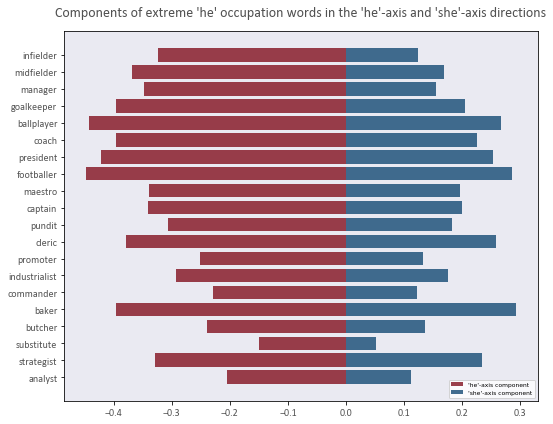

In [ ]:
display_bar_plot(occupation_male, occupation_male_he, occupation_male_she, "'he' occupation")

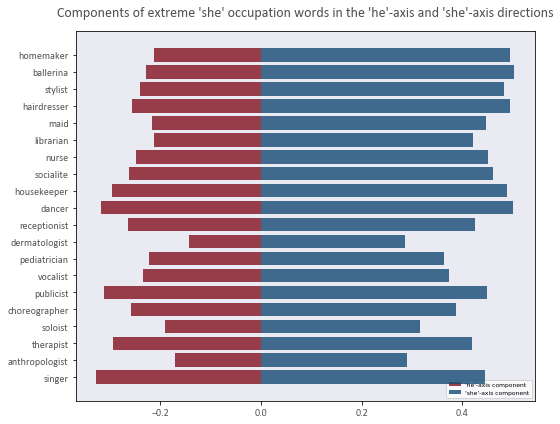

In [ ]:
display_bar_plot(occupation_female, occupation_female_he, occupation_female_she, "'she' occupation")

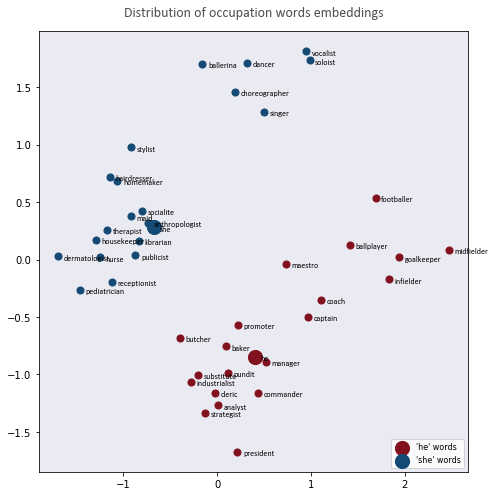

In [ ]:
display_pca_scatterplot(model, anchor_words, occupation_male, occupation_female, 'occupation')

### What about gender stereotypes on personalities?

We also looked at which adjectives were more often assigned to men and to women by applying the same method to personality adjectives.We can find that most of the words used to describe men are positive, while the words used to describe women are more evenly distributed to positive, neutral and negative. Moreover, the adjectives used to describe men are usually related to intelligence and capability, like 'shrewd', 'decisive', 'efficient', 'methodical', 'excellent', 'mercurial', 'smart' etc., while the adjectives used to describe women are usually to describe the appearance and disposition like 'demure', 'dainty', 'beautiful', 'chic', 'angelic', 'sweet', 'saucy', 'delicate', 'fussy', 'vulnerable' etc, which reflects the stereotype of the division of labour between men and women in the society, i.e. men are responsible for labour and production while women are to please men. 

In [ ]:
with open('./wordlists/personality_adjs.txt', 'r') as fin:
    personality_adjs = fin.readlines()
    personality_adjs = [w.strip() for w in personality_adjs]
    
personality_adjs = [w for w in personality_adjs if w in words]

In [ ]:
male_data, female_data = E.find_extreme_words(anchor_words, personality_adjs, select_words_num)
male_data, female_data

([(-0.15464792, 'shrewd'),
  (-0.14514089, 'quick'),
  (-0.144196, 'decisive'),
  (-0.12728946, 'efficient'),
  (-0.12587379, 'average'),
  (-0.122704625, 'crafty'),
  (-0.11668552, 'idle'),
  (-0.11414197, 'good'),
  (-0.11248304, 'amiable'),
  (-0.105056345, 'methodical'),
  (-0.102062754, 'inconsistent'),
  (-0.10069725, 'impressive'),
  (-0.10065998, 'ardent'),
  (-0.097264685, 'excellent'),
  (-0.09475842, 'idiotic'),
  (-0.093657985, 'inactive'),
  (-0.091558486, 'mercurial'),
  (-0.090736285, 'fervent'),
  (-0.09062478, 'revered'),
  (-0.08918859, 'smart')],
 [(0.12964556, 'emotional'),
  (0.13777435, 'musical'),
  (0.1423976, 'playful'),
  (0.14549674, 'drowsy'),
  (0.15054534, 'hysterical'),
  (0.15111913, 'fabulous'),
  (0.15292297, 'sweet'),
  (0.15332118, 'vulnerable'),
  (0.16147567, 'delightful'),
  (0.1684326, 'fussy'),
  (0.18743926, 'delicate'),
  (0.19068134, 'maternal'),
  (0.19720212, 'angelic'),
  (0.1976704, 'nosy'),
  (0.20257452, 'chic'),
  (0.20457783, 'beautif

In [ ]:
male_data.reverse()
personality_adj_male = [w[1] for w in male_data]
personality_adj_male_bias = [w[0] for w in male_data]
personality_adj_male_he = [-E.v(w[1]).dot(E.v('he')) for w in male_data]
personality_adj_male_she = [E.v(w[1]).dot(E.v('she')) for w in male_data]

personality_adj_female = [w[1] for w in female_data]
personality_adj_female_bias = [w[0] for w in female_data]
personality_adj_female_he = [-E.v(w[1]).dot(E.v('he')) for w in female_data]
personality_adj_female_she = [E.v(w[1]).dot(E.v('she')) for w in female_data]

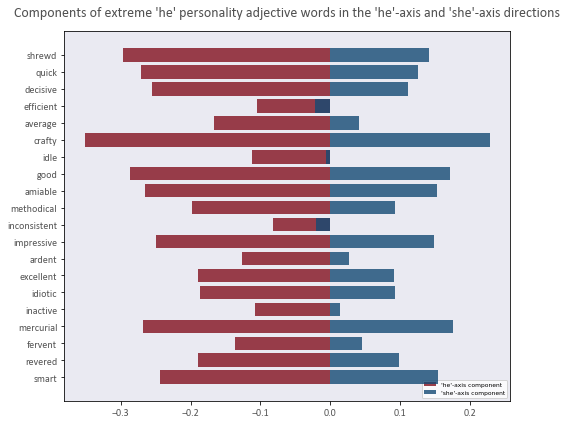

In [ ]:
display_bar_plot(personality_adj_male, personality_adj_male_he, personality_adj_male_she, "'he' personality adjective")

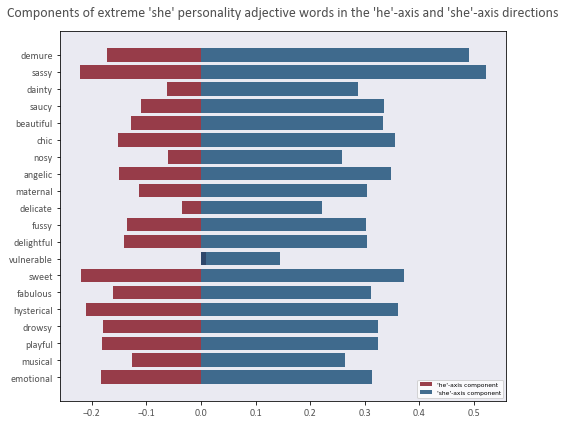

In [ ]:
display_bar_plot(personality_adj_female, personality_adj_female_he, personality_adj_female_she, "'she' personality adjective")

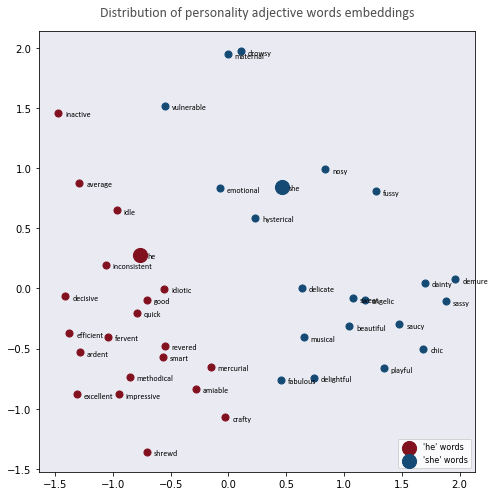

In [ ]:
display_pca_scatterplot(model, anchor_words, personality_adj_male, personality_adj_female, 'personality adjective')

### What analogies can exhibit gender biases?

Analogies are a useful way to both evaluate the quality of a word embedding and also its biases. We used the method proposed by Bolukbasi et al. [1] to generate pairs of words, x and y, such that 'he' to x as 'she' to y is a good analogy. Most of the results are appropriate 'she'-'he' analogies, i.e. the words are definitionally feminine or masculine, which shows the quality of the model we trained is high. 

However, gender stereotype 'she'-'he' analogies still exist. For example, 'pageants'-'boxing' reflects the stereotype of the activities that men and women take part in, and 'hairdresser'-'manager' reflects the inequality of social status of men and women. With regard to personality, analogies like 'voluptuous'-'muscular', 'sexualized'-'combative', 'sexiness'-'athleticism' show the sexual stereotype of gender. The interesting thing is that 'feminist' to 'she' is 'fascist' to 'he' in our embeddings, which shows that feminists are seen to be extremists like fascists. Besides, the analogy of 'instore'-'ingame' implies that women are indulged in shopping while men are addicted to games.

In [ ]:
# Gender direction
v_gender = E.diff('she', 'he')

# Obtain similar analogies
a_gender = E.best_analogies_dist_thresh(v_gender, topn=1000, max_words=50000)

for (a,b,c) in a_gender:
    print(a + "-" + b)

Computing neighbors
Mean: 422.6288927521301
Median: 307.0
she-he
shes-hes
herself-himself
her-his
sister-brother
aunt-uncle
girl-boy
neha-sunil
grandma-grandpa
rousey-khabib
granddaughter-grandson
woman-man
businesswoman-businessman
mother-father
lass-lad
sisterhood-brotherhood
saoirse-defoe
klobuchar-rubio
greatgrandmother-grandfather
alumna-alumnus
motherdaughter-fatherson
sonam-akshay
niece-nephew
lexi-jt
deepika-ranveer
mom-dad
madhuri-rajini
amina-musa
gemma-macca
salma-amir
stassi-cespedes
actress-actor
ananya-sachin
jordyn-foles
hepburn-chamberlain
aishwarya-rajinikanth
mariah-shaq
kirsty-kasper
pelosi-mcconnell
godmother-godfather
housewife-ballplayer
zoey-deon
ms-mr
chlo-thierry
netball-football
brie-jayson
matriarch-patriarch
kidman-gleeson
caitlyn-gronk
ranaut-azam
lili-luc
holm-lemieux
sisterinlaw-brotherinlaw
luann-carmelo
priyanka-shah
priya-tahir
merkel-orban
sania-chhetri
aniston-lebron
anjali-irfan
anushka-rohit
aaliyah-melo
ohara-larkin
shweta-dilip
witherspoon-witten

harlow-mcginn
artista-pulis
tralee-leicester
bikini-mustache
oti-hendo
plump-bony
loosewomen-lineker
croft-carrick
stepmom-rocco
gal-bloke
ying-rui
womans-mans
huffman-peralta
edinburghs-liverpools
latina-hispanics
dcfs-bucor
hairstylist-coach
motherly-fatherly
jamaican-argentinian
puppies-buffaloes
butina-fattah
mckinnon-tannehill
sitharaman-rajapaksa
lynx-jaguars
mamma-papi
aflw-cfl
pregnant-yearsold
infertility-ncds
mothers-countrymen
agt-espn
hormonal-stiffness
lullaby-snare
sasikala-pervez
ronan-didier
socialite-conman
sexualized-combative
bora-saleh
tahiti-uruguay
botswana-khama
neerja-mayank
brexit-salvini
frazzled-undisciplined
kandi-kk
varsity-majorleague
devine-mcallister
filipina-boxer
jaden-garoppolo
bridesmaids-tshirts
hearst-ballard
morrisons-evertons
thunderbirds-rangers
princesses-monarchs
chopra-dravid
spunk-explosiveness
grisham-lackey
manikarnika-imran
duchess-highness
preterm-infarction
raunchy-offthecuff
santa-robles
cleavage-biceps
pelosis-mcconnells
proms-wembley

## Conclusion
Word embeddings furthered our understanding of gender bias in language. The projection of embeddings on 'he' and 'she' directions enabled us to quantify their degree of male- or female-bias. These language biases reflect gender stereotypes in our society, and remind us of the importance of gender equality.

# Part 3 Do people have concerns about gender equality and, if so, what are their attitudes?
Gender bias and inequality have been around for a long time and should be taken seriously, so we used keyword matching to extract texts from Quotebank data related to the topic of gender equality, and counted their popularity, the gender ratio of the topic's followers and used sentiment analysis tools to capture people's attitudes towards the topic.

## Data extraction and sentiment analysis
How to get quotations about gender-equality and emotions embedded in the text of these quotations is a fundamental problem before the follow-up analysis, and it can be very tricky since the data is not annotated. In order to prevent the extraction of irrelevant text that can affect the subsequent data analysis, we are more stringent about accuracy than recall rate when obtaining text. Thus, we used a strict Multi-step keyword matching method to ensure that the text we matched was relevant to gender equality.

For sentiment analysis, we used flair as our analysis tool to classify our texts into Positive and Negative sentiments. 

Note: Because of the long runtime required for quotations extraction and sentiment analysis, we only showed the code here instead of running it, after which we used the generated files directly for data analysis.

In [ ]:
import flair

#These files contain keywords that are considered to be related to the topic of gender equality, here we saperate into several different files because we are going to use them to do a mulitistp matching instead of a direct matching

with open('.\DATA\Gender_related\gender_related_words_firstclass.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_firstclass = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_secondclass.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_secondclass = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_thirdclass.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_thirdclass = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_fourthclass.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_fourthclass = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_fifthclass.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_fifthclass = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_m.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_m = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_f.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_f = set([w.strip() for w in words])

with open('.\DATA\Gender_related\gender_related_words_n.txt', 'r') as infile:
    words = infile.readlines()

gender_word_set_n = set([w.strip() for w in words])

In [ ]:
def clean_text(text):
    # To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    # To consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text) 
    # To replace newline with space
    text = re.sub("\n"," ",text)
    # To convert to lower case
    text = text.lower()

    return text.split()

In [ ]:
#This is the main function to process the multi-step matching
def get_gender_related(file):
    mylist = []
    if file.endswith(('bz2')):
        chunks = pd.read_json(file, compression = 'bz2', lines=True, chunksize=500000)
    else:
        chunks = pd.read_csv(file, chunksize=500000)

    for chunk in chunks:
        origin_quotation = chunk['quotation']
        res = []
        for i, str in enumerate(origin_quotation):
            if i%100 == 0:
                print(i)
            found = 0
            str = clean_text(str)

            #if the string contains tokens in the "firstclass words set", it will be immediately consdered qulified
            for w in gender_word_set_firstclass:
                if w in str:
                    res.append(i)
                    found = 1
                    break
            
            #if the string contains tokens in the "secondclass words set", it will be consdered qulified if it also contains words in "neutral words set" 
            if found == 0:
                for w in gender_word_set_secondclass:
                    if w in str:
                        for w2 in gender_word_set_n:
                            if w2 in str:
                                res.append(i)
                                found = 1
                                break
                        break
            
            #if the string contains tokens in the "thirdclass words set", it will be consdered qulified if it also contains words in "female words set" 
            if found == 0:
                for w in gender_word_set_thirdclass:
                    if w in str:
                        for w2 in gender_word_set_f:
                            if w2 in str:
                                res.append(i)
                                found = 1
                                break
                        break
            
            #if the string contains tokens in the "fifthclass words set", it will be consdered qulified if it also contains words in "male words set"
            if found == 0:
                for w in gender_word_set_fifthclass:
                    if w in str:
                        for w2 in gender_word_set_m:
                            if w2 in str:
                                res.append(i)
                                found = 1
                                break
                        break
            
            #if the string contains tokens in the "fourthclass words set", it will be consdered qulified if it also contains words in both "male words set" and "female words set"
            if found == 0:
                for w in gender_word_set_fourthclass:
                    if w in str:
                        for w2 in gender_word_set_f:
                            if w2 in str:
                                for w3 in gender_word_set_m:
                                    if w3 in str:
                                        res.append(i)
                                        found = 1
                                        break
                                break
                        break
            
        mylist.append(chunk.iloc[res])
    
    new_df = pd.concat(mylist, axis = 0)
    del mylist
    return new_df

#Run through the quotebank file of one year to get all the quotations related to gender equality
new_df = get_gender_related(".\DATA\quote_data\quotes-2016.json.bz2")

In [ ]:
#load the sentiment analysis tool from flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

new_df['pos/neg'] = 'None'
new_df['confidence'] = 'None'

#classifies all the quotations to be "Positive" or "Negative"
for i, row in new_df.iterrows():
    if i%100 == 0:
        print(i)
    s = flair.data.Sentence(row['quotation'])
    flair_sentiment.predict(s)
    total_sentiment = s.labels
    row['pos/neg'] = total_sentiment[0].value
    row['confidence'] = total_sentiment[0].score

    new_df.iloc[i] = row

After the above operation, we got quotations with sentiment types related to gender equality, and after combining them with attributes of the attributer we get the following dataframe for each year

In [ ]:
df_2015 = pd.read_csv('.\Limited_gender_equality\gender_related_sentiment_people_2015.csv')
df_2016 = pd.read_csv('.\Limited_gender_equality\gender_related_sentiment_people_2016.csv')
df_2017 = pd.read_csv('.\Limited_gender_equality\gender_related_sentiment_people_2017.csv')
df_2018 = pd.read_csv('.\Limited_gender_equality\gender_related_sentiment_people_2018.csv')
df_2019 = pd.read_csv('.\Limited_gender_equality\gender_related_sentiment_people_2019.csv')
df_2020 = pd.read_csv('.\Limited_gender_equality\gender_related_sentiment_people_2020.csv')
df_2020.head()

,index_label,index_label.1,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,pos/neg,confidence,Gender,Nationality,Occupation,Party
0,0,0,2020-01-20-001168,A lot of people think the Women's March is jus...,None,[],2020-01-20 04:00:00,1,"[['None', '0.7123'], ['Amanda Jones', '0.2877']]",['http://blogs.dallasobserver.com/news/dallas-...,E,POSITIVE,0.991878,None,None,None,None
1,1,1,2020-02-26-002390,"Additionally, I oppose (bills) mandating schoo...",None,[],2020-02-26 00:00:00,2,"[['None', '0.7974'], ['Andrew Cuomo', '0.2026']]",['http://wxxinews.org/post/mayor-warren-oppose...,E,NEGATIVE,0.996587,None,None,None,None
2,2,2,2020-03-04-008310,But in practice giving a claim of `sex games g...,None,[],2020-03-04 11:02:44,1,"[['None', '0.8985'], ['Harriet Harman', '0.063...",['https://www.independent.co.uk/life-style/wom...,E,NEGATIVE,0.994679,None,None,None,None
3,3,3,2020-01-29-021005,"Finally, as the chief gender champion for the ...",None,[],2020-01-29 01:26:13,1,"[['None', '0.512'], ['Babajide Sanwo-Olu', '0....",['https://thenationonlineng.net/women-need-mor...,E,POSITIVE,0.994985,None,None,None,None
4,4,4,2020-03-11-032994,"Independence Square and Independence Mall, for...",Cynthia MacLeod,['Q5200113'],2020-03-11 17:47:17,1,"[['Cynthia MacLeod', '0.8515'], ['None', '0.12...",['https://www.metro.us/things-to-do/philadelph...,E,POSITIVE,0.998593,[['female']],[['Canada']],[['fiddler']],[['No data']]


In [ ]:
#Then with these new data frame, we generate a dataframe which contains all the information we need for the following data analysis process

#Get the number of quotations related to the topic of gender equality of each year
gender_related_num_2015 = df_2015.shape[0]
gender_related_num_2016 = df_2016.shape[0]
gender_related_num_2017 = df_2017.shape[0]
gender_related_num_2018 = df_2018.shape[0]
gender_related_num_2019 = df_2019.shape[0]
gender_related_num_2020 = df_2020.shape[0]

#The following numbers are calculated in advance with all the data contained in the quotebank dataset, it takes too much time to calculate them again, so we just simply record all the numbers 
total_num_2015 = 20874338
total_num_2016 = 13862129
total_num_2017 = 26611588
total_num_2018 = 27228451
total_num_2019 = 21763302
total_num_2020 = 5244449
female_ratio_2015 = 0.117
female_ratio_2016 = 0.119
female_ratio_2017 = 0.124
female_ratio_2018 = 0.149
female_ratio_2019 = 0.155
female_ratio_2020 = 0.146
male_ratio_2015 = 0.472
male_ratio_2016 = 0.542
male_ratio_2017 = 0.504
male_ratio_2018 = 0.471
male_ratio_2019 = 0.469
male_ratio_2020 = 0.485

#Get the quotations with positive emotion
pos_2015 = df_2015[df_2015['pos/neg'] == 'POSITIVE']
pos_2016 = df_2016[df_2016['pos/neg'] == 'POSITIVE']
pos_2017 = df_2017[df_2017['pos/neg'] == 'POSITIVE']
pos_2018 = df_2018[df_2018['pos/neg'] == 'POSITIVE']
pos_2019 = df_2019[df_2019['pos/neg'] == 'POSITIVE']
pos_2020 = df_2020[df_2020['pos/neg'] == 'POSITIVE']

#calculate the percentage of quotations with positive emotion
pos_percent_2015 = pos_2015.shape[0]/df_2015.shape[0]
pos_percent_2016 = pos_2016.shape[0]/df_2016.shape[0]
pos_percent_2017 = pos_2017.shape[0]/df_2017.shape[0]
pos_percent_2018 = pos_2018.shape[0]/df_2018.shape[0]
pos_percent_2019 = pos_2019.shape[0]/df_2019.shape[0]
pos_percent_2020 = pos_2020.shape[0]/df_2020.shape[0]

#split the quotations by different genders of the attributers
def split_gender(df):
    list_m = []
    list_f = []
    for i, row in df.iterrows():
        if(row['Gender'] != 'None'):
            gender = literal_eval(row['Gender'])
            gender = gender[0][0]
            if gender == 'female':
                list_f.append(i)
            elif gender == 'male':
                list_m.append(i)
    
    df_m = df.iloc[list_m]
    df_f = df.iloc[list_f]
    return df_m, df_f
df_m_2015, df_f_2015 = split_gender(df_2015)
df_m_2016, df_f_2016 = split_gender(df_2016)
df_m_2017, df_f_2017 = split_gender(df_2017)
df_m_2018, df_f_2018 = split_gender(df_2018)
df_m_2019, df_f_2019 = split_gender(df_2019)
df_m_2020, df_f_2020 = split_gender(df_2020)

#calculate the percentage of positive quotations with respect to gender
pos_m_2015 = df_m_2015[df_m_2015['pos/neg'] == 'POSITIVE']
pos_f_2015 = df_f_2015[df_f_2015['pos/neg'] == 'POSITIVE']
pos_m_2016 = df_m_2016[df_m_2016['pos/neg'] == 'POSITIVE']
pos_f_2016 = df_f_2016[df_f_2016['pos/neg'] == 'POSITIVE']
pos_m_2017 = df_m_2017[df_m_2017['pos/neg'] == 'POSITIVE']
pos_f_2017 = df_f_2017[df_f_2017['pos/neg'] == 'POSITIVE']
pos_m_2018 = df_m_2018[df_m_2018['pos/neg'] == 'POSITIVE']
pos_f_2018 = df_f_2018[df_f_2018['pos/neg'] == 'POSITIVE']
pos_m_2019 = df_m_2019[df_m_2019['pos/neg'] == 'POSITIVE']
pos_f_2019 = df_f_2019[df_f_2019['pos/neg'] == 'POSITIVE']
pos_m_2020 = df_m_2020[df_m_2020['pos/neg'] == 'POSITIVE']
pos_f_2020 = df_f_2020[df_f_2020['pos/neg'] == 'POSITIVE']

#Build the new dataframe
Data = {'year' : ['2015', '2016', '2017', '2018', '2019', '2020'],
        'total_num' : [total_num_2015, total_num_2016, total_num_2017, total_num_2018, total_num_2019, total_num_2020],
        'gender_related_num' : [df_2015.shape[0], df_2016.shape[0], df_2017.shape[0], df_2018.shape[0], df_2019.shape[0], df_2020.shape[0]],
        'positive_num' : [pos_2015.shape[0], pos_2016.shape[0], pos_2017.shape[0], pos_2018.shape[0], pos_2019.shape[0], pos_2020.shape[0]],
        'gender_male_num' : [df_m_2015.shape[0], df_m_2016.shape[0], df_m_2017.shape[0], df_m_2018.shape[0], df_m_2019.shape[0], df_m_2020.shape[0]],
        'gender_female_num' : [df_f_2015.shape[0], df_f_2016.shape[0], df_f_2017.shape[0], df_f_2018.shape[0], df_f_2019.shape[0], df_f_2020.shape[0]],
        'gender_male_pos_num' : [pos_m_2015.shape[0], pos_m_2016.shape[0], pos_m_2017.shape[0], pos_m_2018.shape[0], pos_m_2019.shape[0], pos_m_2020.shape[0]],
        'gender_female_pos_num' : [pos_f_2015.shape[0], pos_f_2016.shape[0], pos_f_2017.shape[0], pos_f_2018.shape[0], pos_f_2019.shape[0], pos_f_2020.shape[0]],
        'total_male_num' : [total_num_2015*male_ratio_2015, total_num_2016*male_ratio_2016, total_num_2017*male_ratio_2017, total_num_2018*male_ratio_2018, total_num_2019*male_ratio_2019, total_num_2020*male_ratio_2020],
        'total_female_num' : [total_num_2015*female_ratio_2015, total_num_2016*female_ratio_2016, total_num_2017*female_ratio_2017, total_num_2018*female_ratio_2018, total_num_2019*female_ratio_2019, total_num_2020*female_ratio_2020]}
new_df = pd.DataFrame(Data)
new_df['total_male_num'] = new_df['total_male_num'].astype(int)
new_df['total_female_num'] = new_df['total_female_num'].astype(int)
new_df = new_df.iloc[0:5]   #Here we don't consider the data from year 2020, because this year's data in quotebank is not compelete
new_df['gender_related_percent'] = new_df['gender_related_num']*1.0/new_df['total_num']*100
new_df['male_ratio'] = new_df['gender_male_num']*1.0/new_df['total_male_num']*100
new_df['female_ratio'] = new_df['gender_female_num']*1.0/new_df['total_female_num']*100
new_df['positive_total_ratio'] = new_df['positive_num']*1.0/new_df['gender_related_num']*100
new_df['positive_male_ratio'] = new_df['gender_male_pos_num']*1.0/new_df['gender_male_num']*100
new_df['positive_female_ratio'] = new_df['gender_female_pos_num']*1.0/new_df['gender_female_num']*100
new_df

,year,total_num,gender_related_num,positive_num,gender_male_num,gender_female_num,gender_male_pos_num,gender_female_pos_num,total_male_num,total_female_num,gender_related_percent,male_ratio,female_ratio,positive_total_ratio,positive_male_ratio,positive_female_ratio
0,2015,20874338,20013,8319,6609,5551,2732,2414,9852687,2442297,0.095874,0.067078,0.227286,41.567981,41.337570,43.487660
1,2016,13862129,16159,6832,5164,4375,2172,1942,7513273,1649593,0.116569,0.068732,0.265217,42.279844,42.060418,44.388571
2,2017,26611588,32975,14727,10294,9527,4699,4320,13412240,3299836,0.123912,0.076751,0.288711,44.661107,45.647950,45.344809
3,2018,27228451,35669,16704,10735,9956,5029,4903,12824600,4057039,0.130999,0.083706,0.245401,46.830581,46.846763,49.246685
4,2019,21763302,29186,13937,9108,7885,4353,4073,10206988,3373311,0.134106,0.089233,0.233747,47.752347,47.793149,51.655041


## Data analysis and visualization

### How much attention are people paying to the gender equality-related topic?
We counted gender equality-related quotations as a percentage of the total number of all quotations in the dataset for five consecutive years （2015-2019）, and the results are shown in the figure below：

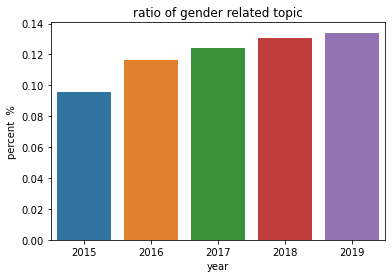

In [ ]:
sns.barplot(x="year", y="gender_related_percent", data=new_df)
plt.ylabel("percent  %")
plt.title("ratio of gender related topic")
plt.show()

We found that the percentage of quotations about gender equality in each of the five years was around 1 in 1,000, which is clearly not a very high percentage (even if it is influenced by the incomplete data we collected on gender equality), and something as important as gender equality should have received much more attention.The good news, however, is that this percentage increased every year, suggesting that people were paying more attention to this issue. 

### Is gender equality  of equal concern to different gender groups？
We counted the number of gender-specific topics raised by gender equality and the percentage of the respective gender groups, and the following graphs were obtained.

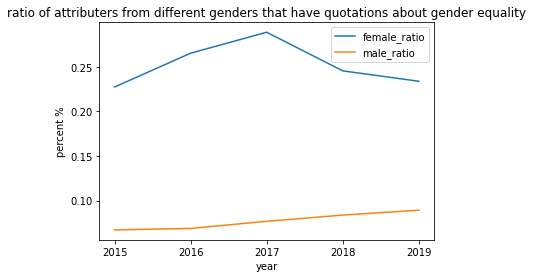

In [ ]:
sns.lineplot(x="year", y="female_ratio", data=new_df, label = 'female_ratio')
sns.lineplot(x="year", y="male_ratio", data=new_df, label = 'male_ratio')
plt.title("ratio of attributers from different genders that have quotations about gender equality")
plt.ylabel("percent %")
plt.legend(loc='upper right')
plt.show()

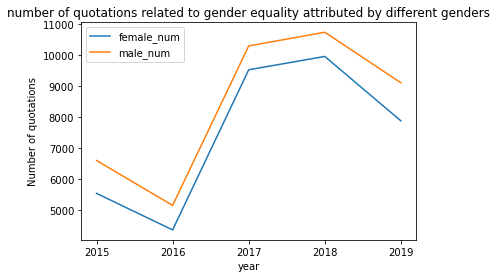

In [ ]:
sns.lineplot(x="year", y="gender_female_num", data=new_df, label = 'female_num')
sns.lineplot(x="year", y="gender_male_num", data=new_df, label = 'male_num')
plt.title("number of quotations related to gender equality attributed by different genders")
plt.ylabel("Number of quotations")
plt.legend(loc='upper left')
plt.show()

In terms of numbers, the number of men following the topic of gender equality is higher than the number of women following the topic. But proportionally, the rate of women following it is much higher than that of men. Here are two plausible explanations for the results from our perspectives:

1.Men are significantly less concerned about gender equality than women, which is not the way it should be. Though women are often considered as the victims of sexism, gender stereotypes can also be harmful to men, since each of us is a stakeholder in gender equality. Hence men need to be more concerned about gender equality, and fortunately, we have observed such a trend in this five-year continuous data.

2.Women have too few opportunities to be heard, and the percentage of women in all attributers is far lower than that of men. Women deserve more opportunities to speak up and be heard in all areas rather than not being noticed until they start to fight for their rights


### What are people's attitudes toward gender equality, positive or negative?
First, we analyzed the percentage of quotations with positive attitudes toward gender equality.

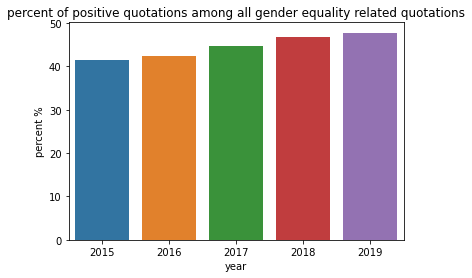

In [ ]:
sns.barplot(x="year", y="positive_total_ratio", data=new_df)
plt.ylabel("percent %")
plt.title("percent of positive quotations among all gender equality related quotations")
plt.show()

While the majority of people are still negative about the topic of gender equality, we can clearly see a growth in the percentage of people with positive views, which is great news. Keep it going!

What we have analyzed so far is on the overall attitude of people. However, if we divide the population by gender, will there be any differences in attitudes towards gender equality between men and women?

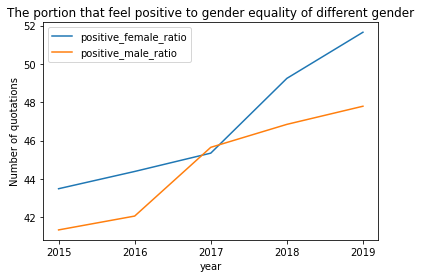

In [ ]:
sns.lineplot(x="year", y="positive_female_ratio", data=new_df, label = 'positive_female_ratio')
sns.lineplot(x="year", y="positive_male_ratio", data=new_df, label = 'positive_male_ratio')
plt.title("The portion that feel positive to gender equality of different gender")
plt.ylabel("Number of quotations")
plt.legend(loc='upper left')
plt.show()

The female population is generally more optimistic than the male population, but this is not intuitive, as women are often more vulnerable to persecution for gender inequality. After taking these into consideration, the following reasons come to our mind:

1.Generally speaking, men are less concerned about gender equality, and thus men who focus on the topic of gender equality have higher probability to have experienced or observed such events with an overwhelmingly severe level of inequality, that they are more likely to hold a pessimistic view.

2.Another possible reason is the growing awareness of gender inequality among men. Their awareness of the magnitude of sexism, and their concern and voice for it, have led women to believe there is hope for improvement, and becoming more optimistic.


## Conclusion
The topic of gender equality is gaining more and more attention, but its still needs more people, especially more men, to pay attention to it. The situation has improved in recent years, but in general there are still serious inequalities, and we need to maintain and accelerate the current trend of increasing gender equality.

# References
[1] 	T. Bolukbasi, K.-W. Chang, J. Zou, V. Saligrama and A. Kalai, "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings," in Proceedings of the 30th International Conference on Neural Information Processing Systems, Barcelona, Spain, 2016. 

[2] 	T. Vaucher, A. Spitz, M. Catasta and R. West, "Quotebank: A Corpus of Quotations from a Decade of News," in Proceedings of the 14th ACM International Conference on Web Search and Data Mining, Virtual Event, Israel, 2021. 

[3] 	T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado and J. Dean, "Distributed Representations of Words and Phrases and their Compositionality," in Advances in Neural Information Processing Systems, 2013. 
